In [4]:
import numpy as np
from numpy.polynomial.hermite_e import hermefit, hermeval
import matplotlib.pyplot as plt
rng = np.random.default_rng()

# Part 1 (Question 1 & 2)

## Ex1.1

In [5]:
# 1.1
def coeffsForCondiExp(X,Y,hermiteOrder):
    return hermefit(X, Y, hermiteOrder)

# beta = coeffsForCondiExp(X,Y,hermiteOrder)

def approxCondExp(X,beta):
    return hermeval(X, beta)

## Exercise2.1
The BSDE is given by:
$$
d Y_{t}=\left[r Y_{t}+\sigma^{-1}(\mu-r) Z_{t}\right] d t+Z_{t} d W_{t}, t \in[0, T], Y_{T}=\xi 
$$

$
\text { where } \xi=\left[S_{T}-K\right]_{+} \text {for } K>0 \text { fixed and } d S_{t}=\mu S_{t} d t+\sigma S_{t} d W_{t}
$

The solution of $S_{t}$ is
$$
S_{t}=S_{0} \exp \left(\left(\mu-\frac{\sigma^{2}}{2}\right) t+\sigma W_{t}\right)
$$

We first simulate the brownian motion and then solve the BSDE numerically

In [6]:
def simulate_BM(S0 = 1, mu = 0.03, sigma = 0.2, T = 1, N = 100, N_mc = 10**3):
    dt = float(T)/N
    t=np.linspace(0,T,N)
    #  initialize the brownian motion
    dW_df = np.zeros((N_mc,N-1))
    W_T = np.zeros(N_mc)
    
    #  initialize the Underlying asset St, N_mc paths,N time points
    S_df = np.zeros((N_mc,N))
    
    #simuliate the brownian motion & St for N_mc paths
    for i in range(N_mc):
        dW=np.sqrt(dt)*np.random.randn(1,N-1)
        dW_df[i] = dW
        
        W=np.cumsum(dW) 
        W_T[i] = W[-1] 
        
        Xtrue=S0*np.exp((mu-0.5*sigma**2)*t[1:]+sigma*W)
        Xtrue=np.insert(Xtrue,0,S0)
        S_df[i] = Xtrue
        
    return dW_df, W_T, S_df

In [7]:
dW_df, W_T, S_df = simulate_BM()

The folowwing is the explicit solution of the BSDE

Our interested BSDE is 
$$
d Y_{t}=\left[r Y_{t}+\sigma^{-1}(\mu-r) Z_{t}\right] d t+Z_{t} d W_{t}, t \in[0, T], Y_{T}=\xi 
$$
Set 
$$
g_{t}(y,z)=ry_{t}+\dfrac{\mu-r}{\sigma}z_{t}, \phi = \dfrac{\mu-r}{\sigma}
$$
Consider the measure $\mathbb{Q}$ given by Radon-Nikodym derivative
$$
\dfrac{d\mathbb{Q}}{d\mathbb{P}}=\exp(-\dfrac{1}{2}\int_{0}^{T}\phi^{2}dt-\int_{0}^{T}\phi dW_{t})=\exp(-\dfrac{T}{2}\phi^{2}-\phi W_{T})
$$
The expectation of the Radon-Nikodym derivative is 1, this can be checked easily. Then due to Girsanov's Theorem we have 
$$
W^{\mathbb{Q}}_{t}=W_{t}+\int_{0}^{t}\phi ds = W_{t} + \phi t
$$
is a $\mathbb{Q}$-Wiener process. 
Consider this BSDE

$$
d\bar{Y}_{t}=\bar{Z}_{t}dW_{t}^{\mathbb{Q}}; \ \bar{Y}_{t} = \bar{\xi}
$$
Where $\bar{\xi} = \xi\exp(-rT)$. 
Let $Y_{t} = \bar{Y}_{t}\exp(rt)$, $\bar{Z}_{t} = Z_{t}\exp(rt)$
By Ito's formula, we have the following:
$$
\begin{aligned}
dY_{t}&=d(\bar{Y}_{t}\exp(rt))\\
&=re^{rt}\bar{Y}_{t}dt+e^{rt}d\bar{Y}_{t}\\
&=rY_{t}dt+Z_{t}dW_{t}^{\mathbb{Q}}
\end{aligned}
$$
Then we can get:
$$
\begin{aligned}
d\mathrm{E}^{\mathbb{Q}}(Y_{t}|\mathcal{F}_{t}) = \mathrm{E}^{\mathbb{Q}}(Y_{t}|\mathcal{F}_{t})rdt\\
\dfrac{d\mathrm{E}^{\mathbb{Q}}(Y_{t}|\mathcal{F}_{t})}{\mathrm{E}^{\mathbb{Q}}(Y_{t}|\mathcal{F}_{t})}=rdt\\
\log(\mathrm{E}^{\mathbb{Q}}(\xi|\mathcal{F}_{t}))-\log(Y_{t})=r(T-t)\\
Y_{t} = \mathrm{E}^{\mathbb{Q}}(\xi e^{(-r(T-t))}|\mathcal{F}_{t})
\end{aligned}
$$
Finally we have: 
$$
\begin{aligned}
Y_{t}&=\dfrac{\mathrm{E}(\xi e^{(-r(T-t))}e^{\left(-\frac{T}{2} \phi^{2}-\phi W_{T}\right)}|\mathcal{F}_{t})}{\mathrm{E}(e^{\left(-\frac{T}{2} \phi^{2}-\phi W_{T}\right)}|\mathcal{F}_{t})}\\
&=\dfrac{\mathrm{E}(\xi e^{(-r(T-t))}e^{\left(-\phi W_{T}\right)}|\mathcal{F}_{t})}{\mathrm{E}(e^{\left(-\phi W_{T}\right)}|\mathcal{F}_{t})}
\end{aligned}
$$

The numerical solution is implemented as:
$$
\begin{array}{l}
Y_{i} \approx \mathbb{E}_{t_{i}}\left[Y_{i+1}-g_{i}\left(Y_{i+1}, Z_{i}\right) \Delta t_{i+1}\right], i=0,1, \ldots, N-1, Y_{N}=\xi \\
Z_{i} \approx \frac{1}{\Delta t_{i+1}} \mathbb{E}_{t_{i}}\left[Y_{i+1} \Delta W_{i+1}\right]
\end{array}
$$

In [8]:
def get_solution_BSDE(S0 = 1, mu = 0.03, sigma = 0.2, T = 1, N = 100, N_mc = 10**3,
                      K = 1, r = 0.01, N_basis_f = 50):
    dt = float(T)/N
    t=np.linspace(0,T,N)
    #  initialize the simulated Yt process
    Y_df = np.zeros((N_mc,N))
    #  initialize the explicit Yt process, it will help us check the 'simulated Yt' convergence to the exact solution
    Ytrue_df = np.zeros((N_mc,N))
    
    #set the initial value Y_T for each path (terminal condition)
    for i in range(N_mc):
        Y_df[i,-1] = max(S_df[i,-1]-K,0)
        Ytrue_df[i,-1] = max(S_df[i,-1]-K,0)##explicit solution
        
    Z_df = np.zeros((N_mc,N-1))
    
    for i in range(N-2,-1,-1):
        #Simulated Yt process
        # according to the iterative formula, estimate the condition value for Z and simulated Y for each time step
        beta_Z = coeffsForCondiExp(S_df[:,i],Y_df[:,i+1]*dW_df[:,i],N_basis_f)
        Z_df[:,i] = approxCondExp(S_df[:,i],beta_Z)/dt
    
        beta_Y = coeffsForCondiExp(S_df[:,i],Y_df[:,i+1] - (r*Y_df[:,i+1] + sigma**(-1)*(mu-r)*Z_df[:,i])*dt,N_basis_f)
        Y_df[:,i] = approxCondExp(S_df[:,i],beta_Y)
        
        #exact process for Yt according to the explicit solution
        beta_Ytrue_denominator = coeffsForCondiExp(S_df[:,i],np.exp(-(mu-r)/sigma*W_T),N_basis_f)
        beta_Ytrue_numerator = coeffsForCondiExp(S_df[:,i],np.exp(-(mu-r)/sigma*W_T)*Y_df[:,-1],N_basis_f)
        Ytrue_df[:,i] = np.exp(-r*(T-dt*(i+1)))*approxCondExp(S_df[:,i],beta_Ytrue_numerator)/approxCondExp(S_df[:,i],beta_Ytrue_denominator)
    return Y_df, Ytrue_df, t, N_mc

In [9]:
Y_df, Ytrue_df, t, N_mc=  get_solution_BSDE()

D:\Anaconda\lib\site-packages\numpy\polynomial\hermite_e.py:1371: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


Then we solve the BSDE with the parameter settings: $S_0 = 1$, $\mu = 0.03$, $\sigma = 0.2$, $T = 1$, $N = 100$, $N_mc = 1000$,
 $K = 1$, $r = 0.01$, $N_{\text{basis}} = 50$
 
 We can change the parameters just simply rerun the function defined above and change the input.

Next we randomly select the sample path calculated previously to make a comparison with the exact solution.

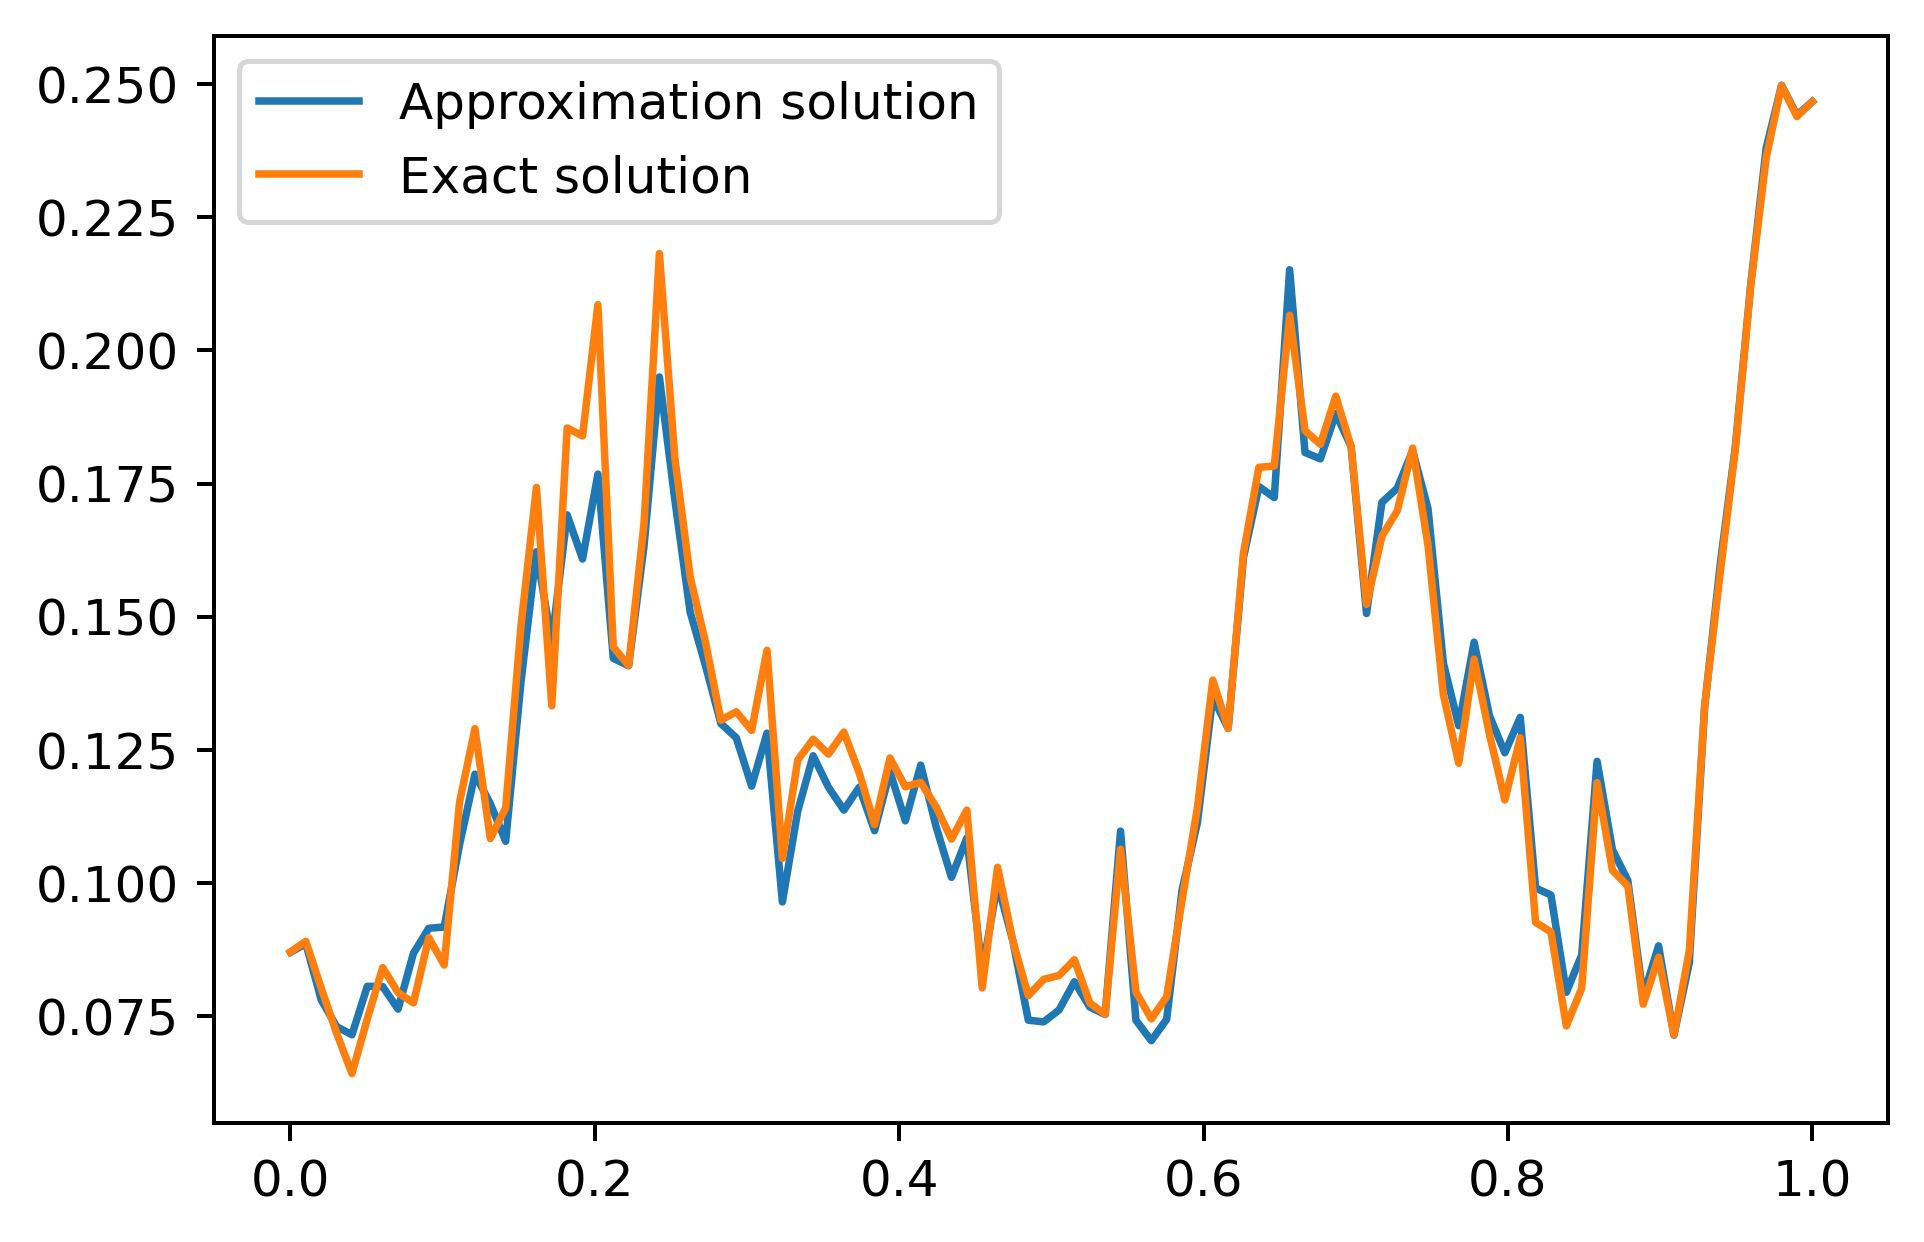

In [10]:
fig = plt.figure(1,dpi = 360) 
rnd_sample = np.random.randint(0,N_mc)
ax1=plt.subplot(111)   
l1,=ax1.plot(t,Y_df[rnd_sample])
l2,=ax1.plot(t,Ytrue_df[rnd_sample])
plt.legend(handles=[l1,l2,],labels=['Approximation solution','Exact solution'],loc='best')
plt.show()

In [11]:
error = 0
for i in range(N_mc):
    error += np.sum(np.power((Y_df[i]-Ytrue_df[i]),2))
    error = error/N_mc
print(f'The error is {error}')

The error is 3.6237760901458275e-05


## Convergence test


### 1.Different Monte Carlo samples

#### Warning!  
The cell may take 1 minute to run

In [12]:
mc = [i*100 for i in range(1,31)]
test_error_mc = []
for i in range(0,30):
    dW_df, W_T, S_df = simulate_BM(N_mc=mc[i])
    Y_df, Ytrue_df, t, N_mc=  get_solution_BSDE(N_mc=mc[i])
    error = 0
    for i in range(N_mc):
        error += np.sum(np.power((Y_df[i]-Ytrue_df[i]),2))
        error = error/N_mc
    test_error_mc.append(error)

D:\Anaconda\lib\site-packages\numpy\polynomial\hermite_e.py:1371: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


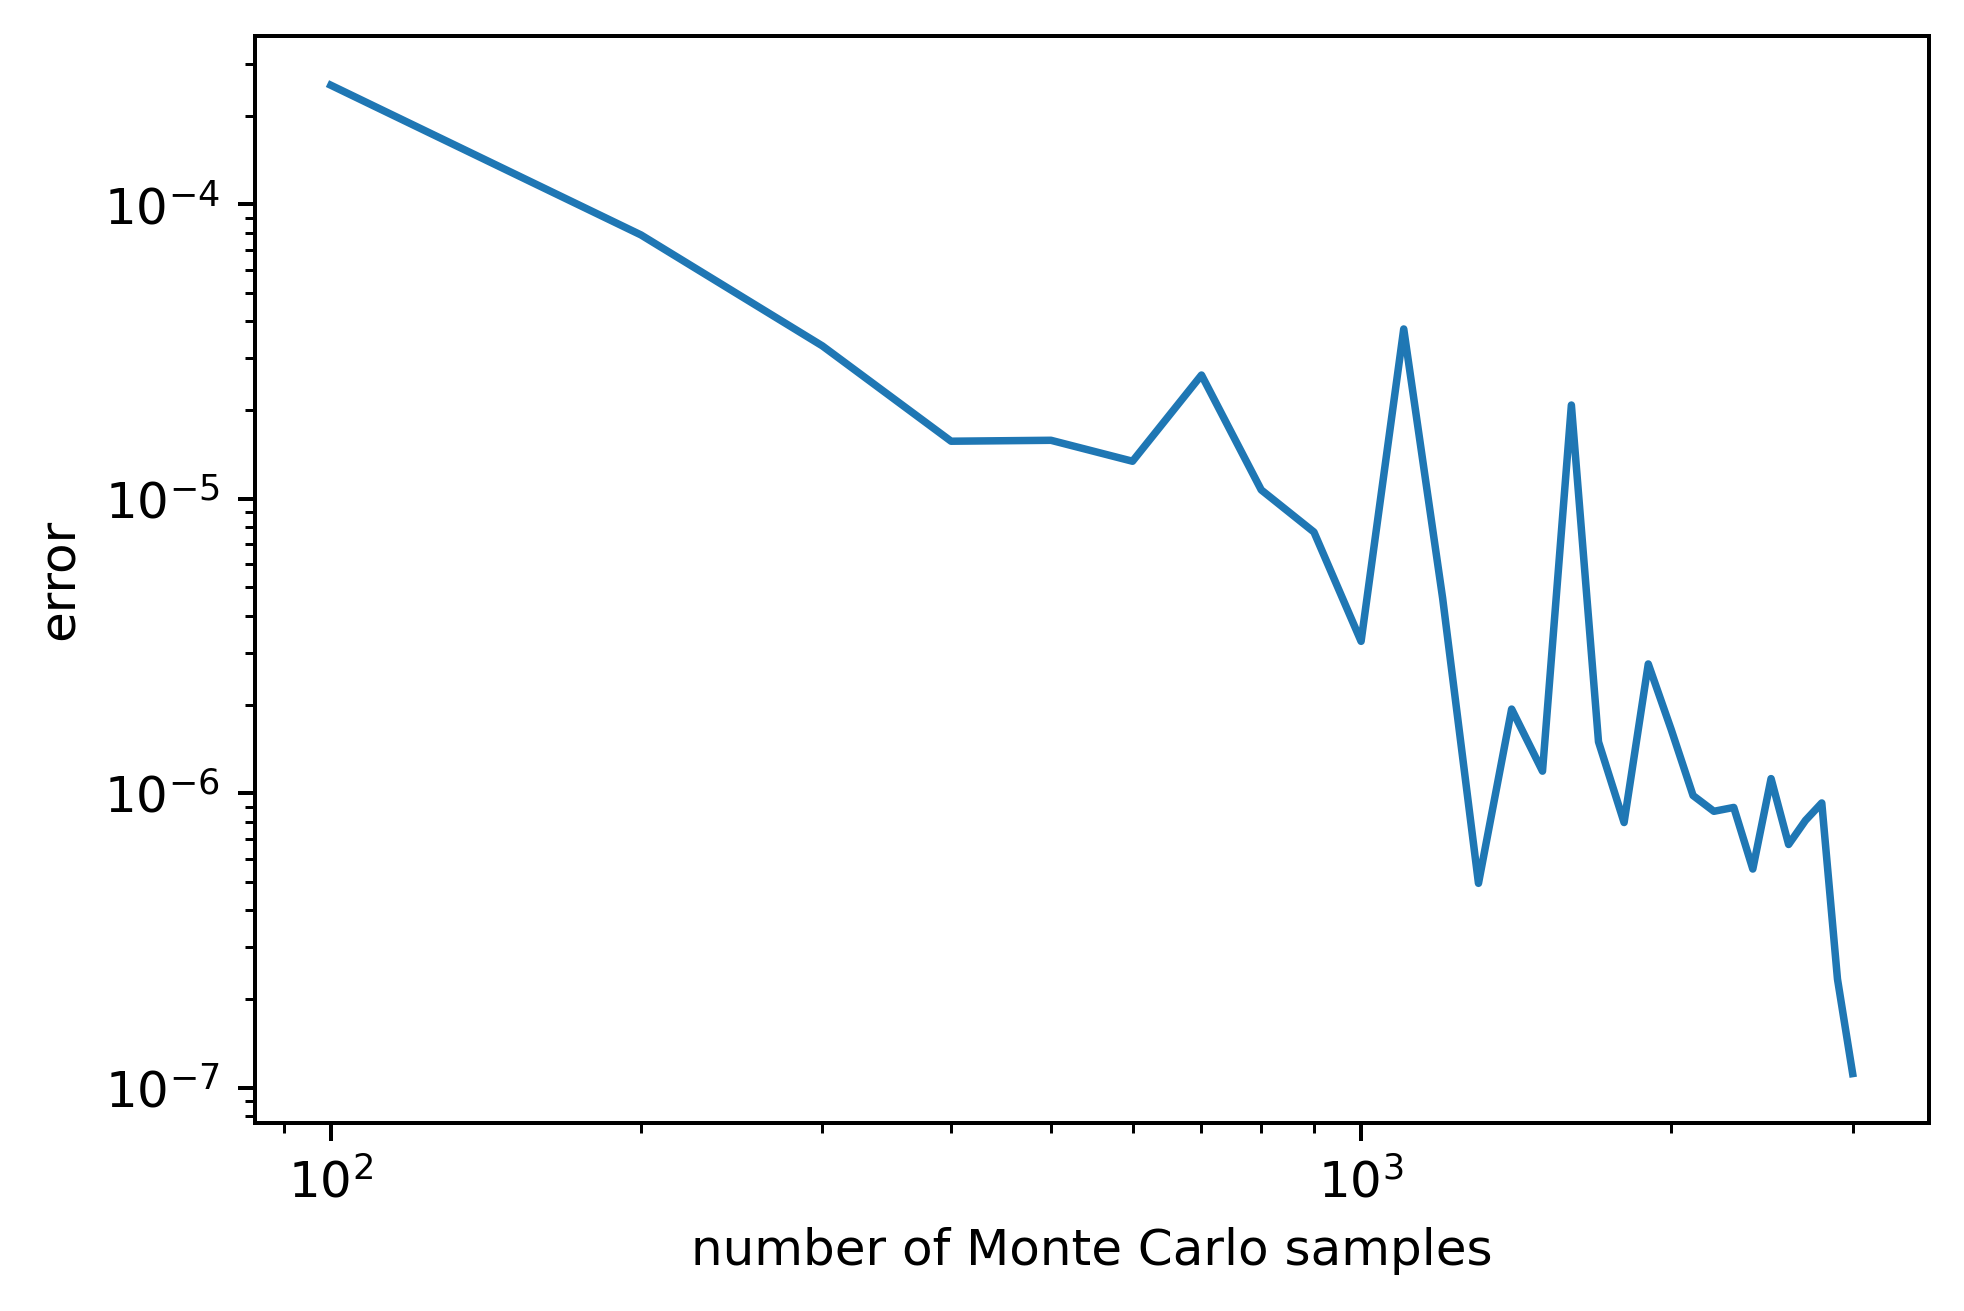

In [13]:
plt.figure(dpi=360)
plt.xlabel('number of Monte Carlo samples')
plt.ylabel('error')
plt.loglog(mc,test_error_mc)

## 2. Diiferent time step

#### Warning!  
The cell may take 3 minutes to run

In [14]:
ts = [i*35 for i in range(1,26)]
test_error_ts = []
for i in range(0,25):
    dW_df, W_T, S_df = simulate_BM(N=ts[i])
    Y_df, Ytrue_df, t, N_mc=  get_solution_BSDE(N=ts[i])
    error = 0
    for i in range(N_mc):
        error += np.sum(np.power((Y_df[i]-Ytrue_df[i]),2))
        error = error/N_mc
    test_error_ts.append(error)

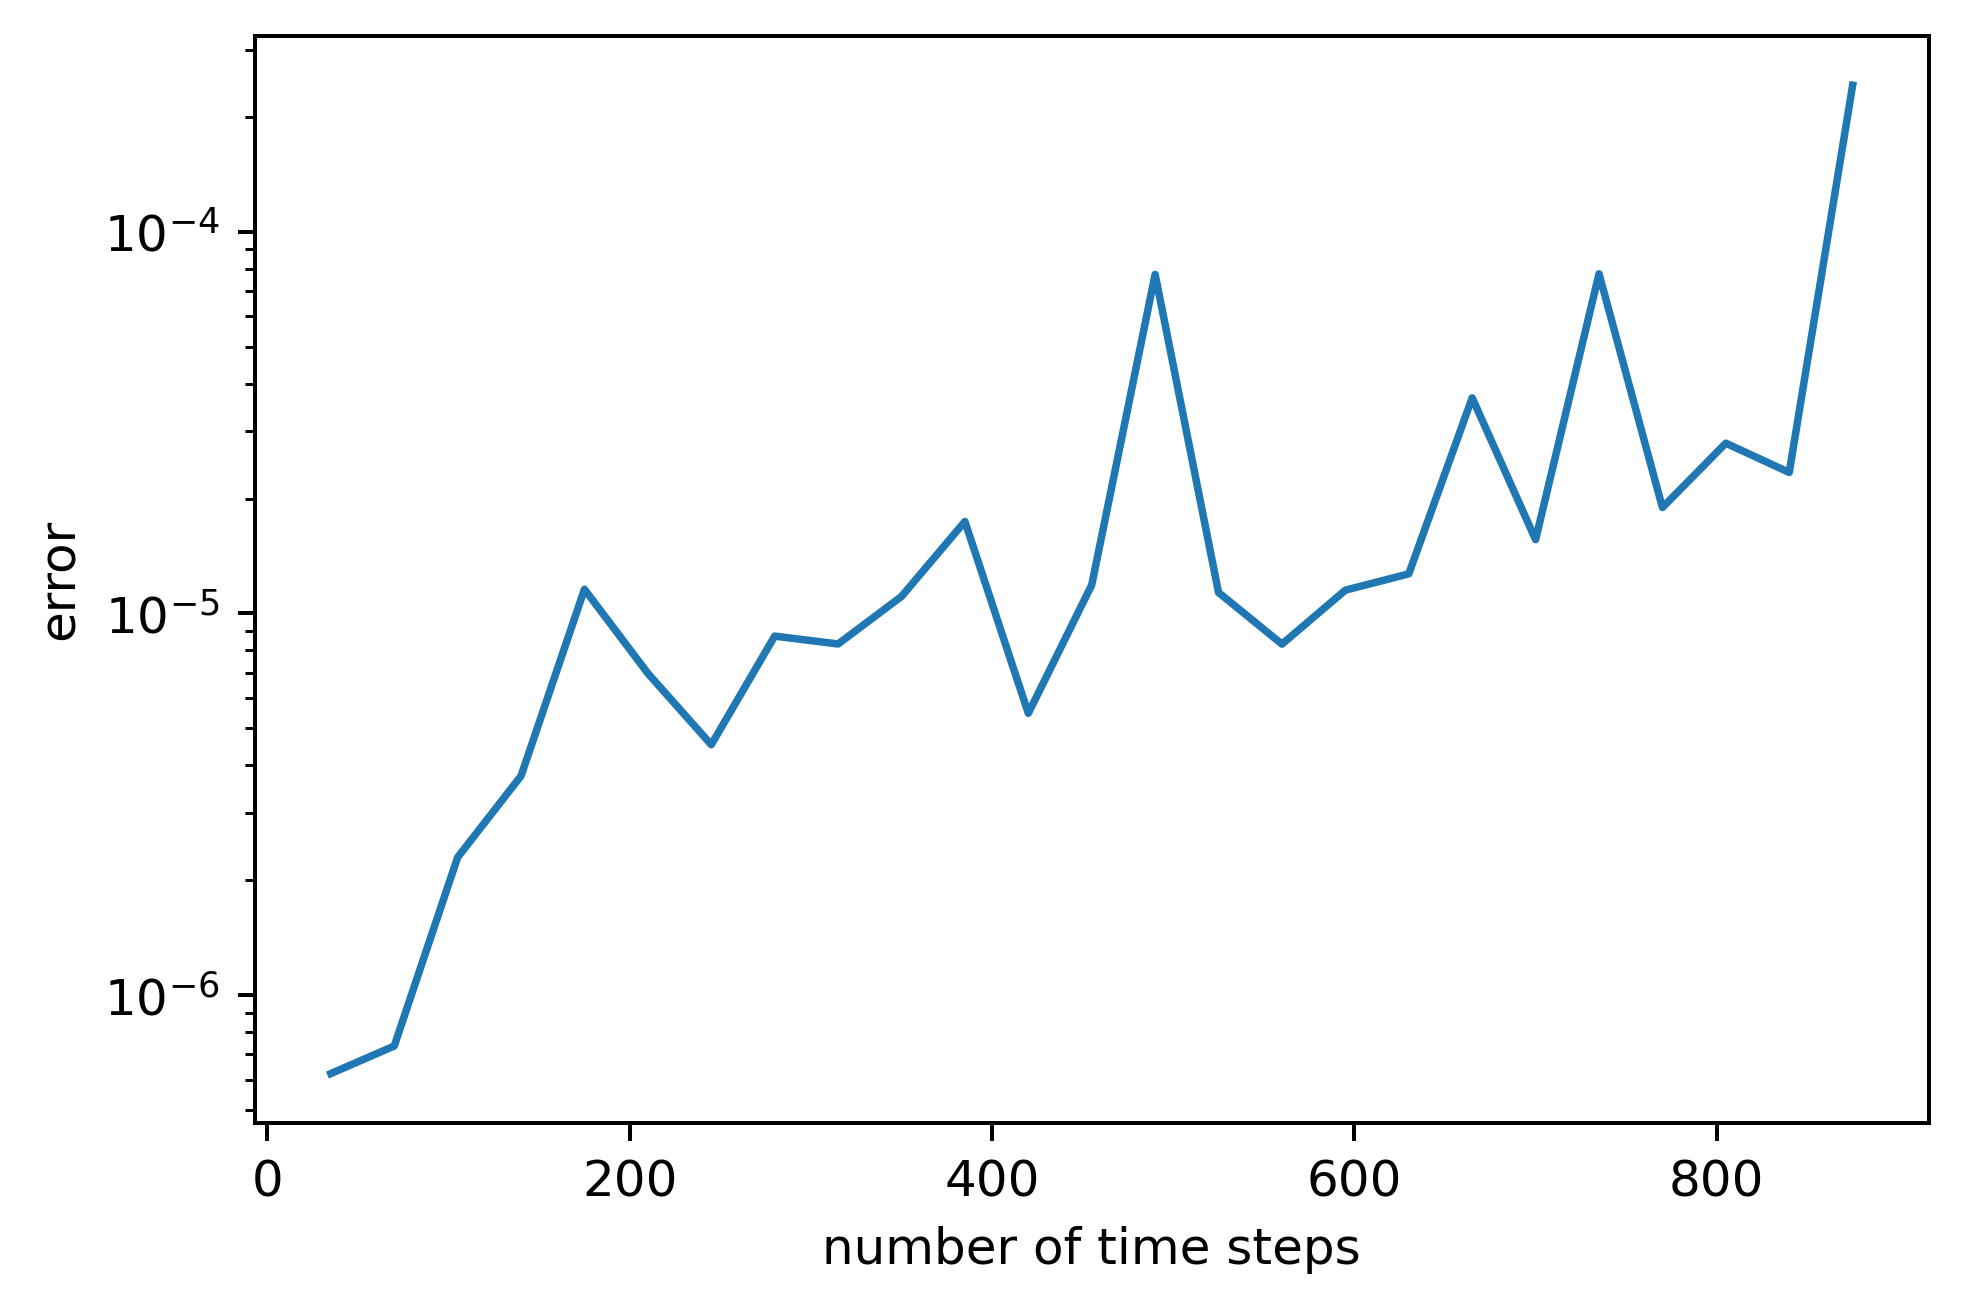

In [15]:
plt.figure(dpi=360)
plt.xlabel('number of time steps')
plt.ylabel('error')
plt.semilogy(ts,test_error_ts)

## 3. Different number of basis functions

#### Warning!  
The cell may take 2 minutes to run

In [16]:
basis = [i*10 for i in range(1,21)]
test_error_basis = []
for i in range(0,20):
    dW_df, W_T, S_df = simulate_BM()
    Y_df, Ytrue_df, t, N_mc=  get_solution_BSDE(N_basis_f=basis[i])
    error = 0
    for i in range(N_mc):
        error += np.sum(np.power((Y_df[i]-Ytrue_df[i]),2))
        error = error/N_mc
    test_error_basis.append(error)

D:\Anaconda\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
D:\Anaconda\lib\site-packages\numpy\polynomial\polyutils.py:706: RuntimeWarning: overflow encountered in square
  scl = np.sqrt(np.square(lhs).sum(1))


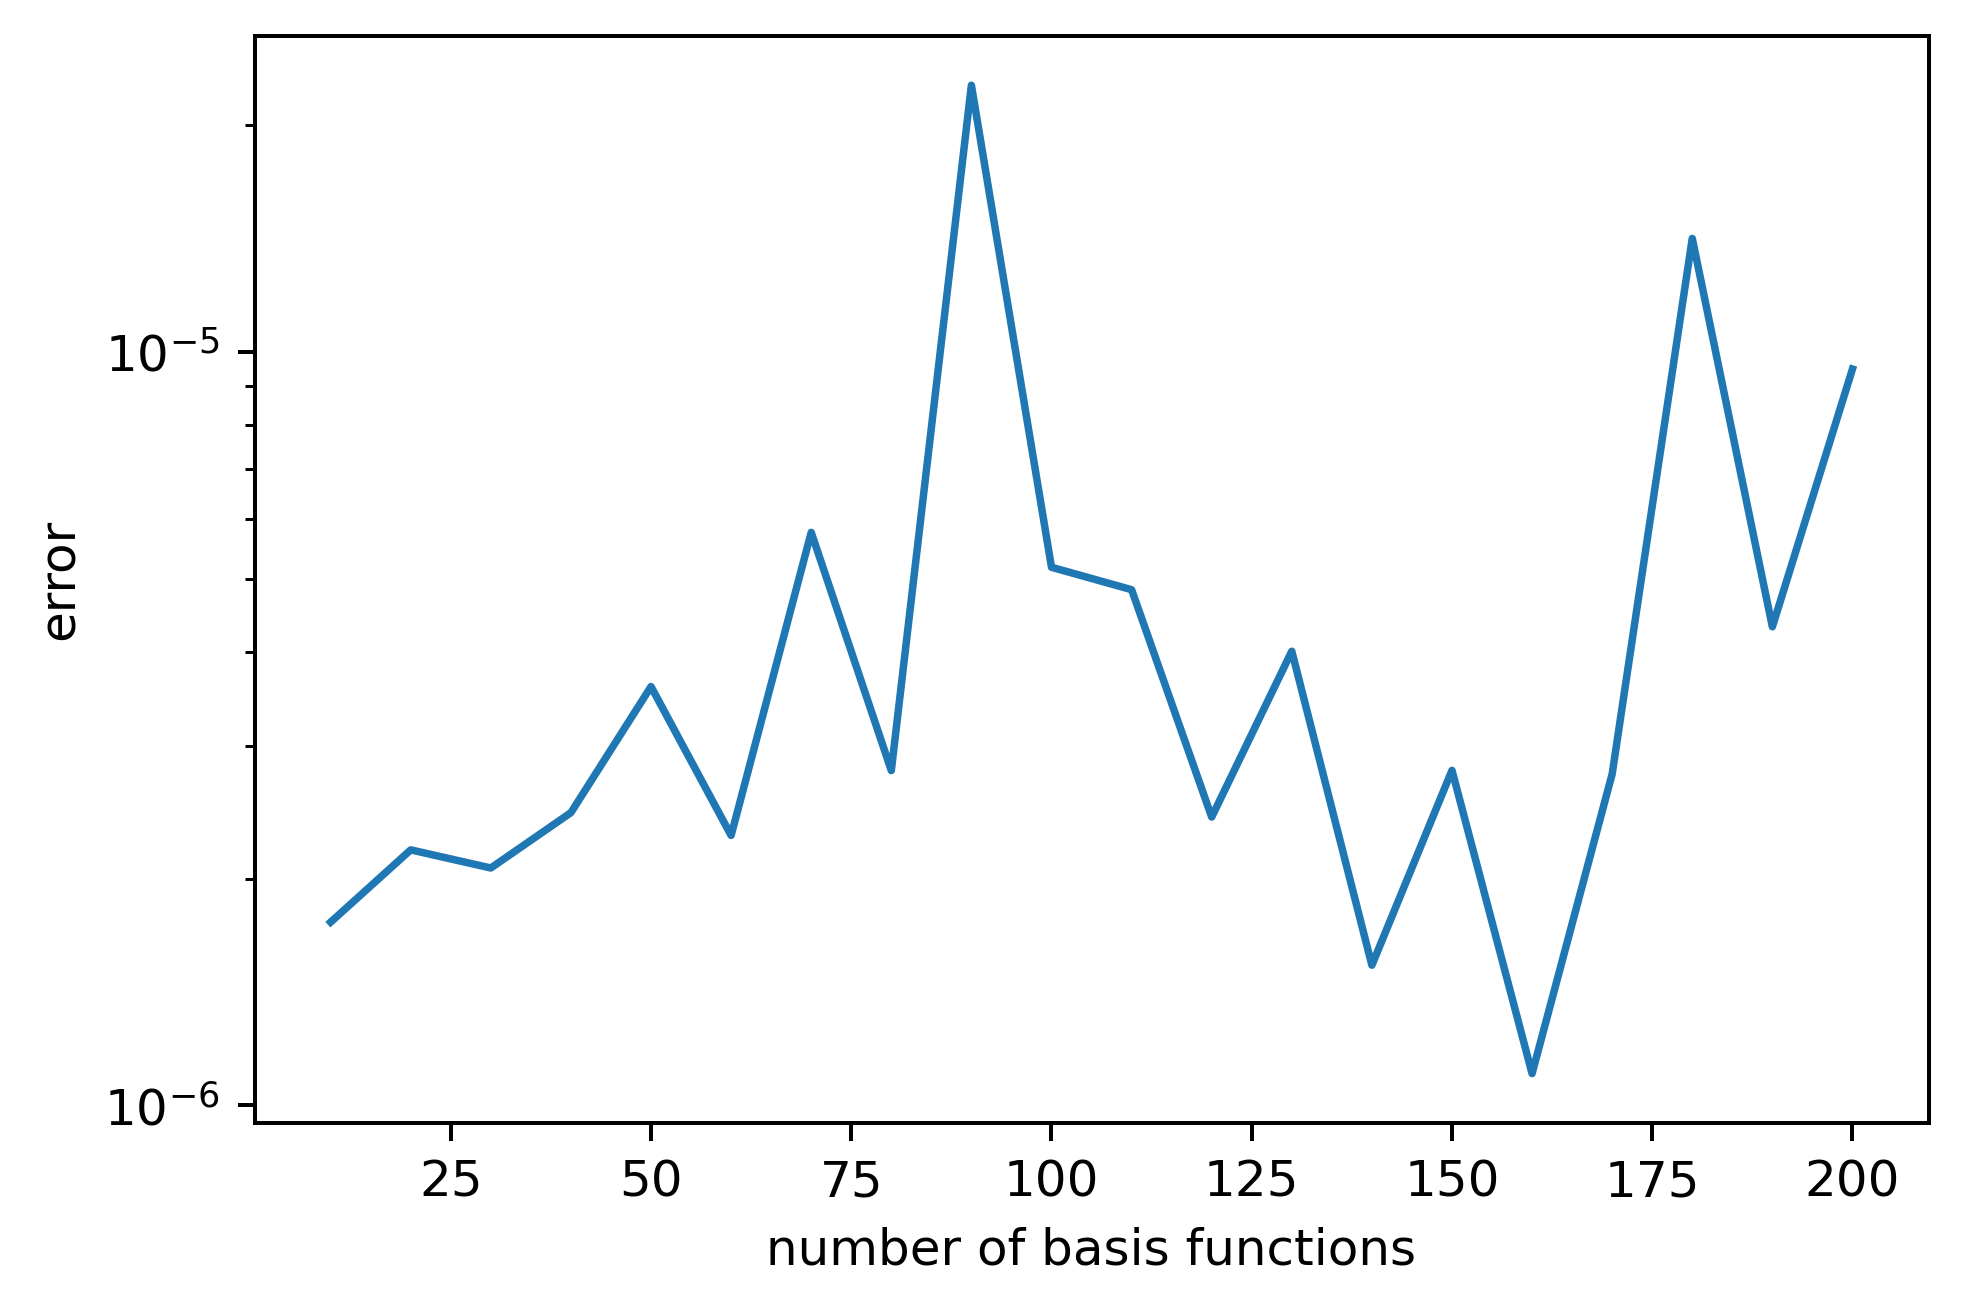

In [17]:
plt.figure(dpi=360)
plt.xlabel('number of basis functions')
plt.ylabel('error')
plt.semilogy(basis,test_error_basis)

### Comments

We can see that the more Monte Carlo samples, the lower error we have but with fluctuation. However, the overall trend is downward as the sample path increase.

For the time step, as the time step get smaller, the test error experience an upward trend with fluctuation

As for the different number of basis functions, we can make a really good approximation using 20 to 50 basis function, however, as the basis number goes up, the function may over-fitting the conditional expectation, which will increase the variance and the test erorr increase. 

# Part 2 (Question 3)

## Basic settings

In [18]:
# set the parameters
x0 = 1 
L = 1 
M =1
R = -3
F = 1
C = -10
D = -5
T = 1

epsilon = 10**(-4)# stopping criteria
delta = 10**(-4) # udpating rate

## Our model
Our deterministic SDE is given by
$$d X_{t}=\left[L(t) X_{t}+M(t) \alpha_{t}\right] d t,\text{ for $t\in [0,T]$ }\quad X_0=x_0$$
Where $L=L(t)\in \mathbb{R}$, $M=M(t)\in \mathbb{R}$ are bounded and deterministic function of t, in our settings, we set them to be constant(the same argument on $F,C,D$).

The running reward $f$:
$$f(t,X_{t},\alpha_{t})=C(t) X^2_{t}+D(t) \alpha^2_{t}+2 X_{t} F(t) \alpha_{t}$$
Further let $C=C(t) \in \mathbb{R}, D=D(t) \in \mathbb{R}, F=F(t) \in \mathbb{R}$ be deterministic, integrable functions of $t$and $R \in \mathbb{R}$ be such that $C, D$ and $R$ are symmetric, $C=C(t) \leq 0, R \leq 0$ and $D=D(t) \leq-\delta<0$ with some constant $\delta>0 .$ The aim will be to maximize
$$
\begin{aligned}
J^{\alpha}(x):=\mathbb{E}^{x, \alpha}\left[\int_{0}^{T}\left[C(t) X^2_{t}+D(t) \alpha^2_{t}+2 X_{t} F(t) \alpha_{t}\right] d t+X_{T}^{2} R\right]\\
\text { over all adapted processes } \alpha \text { such that } \mathbb{E} \int_{0}^{T} \alpha_{t}^{2} d t<\infty
\end{aligned}
$$

Let $b(t,X_{t},\alpha_{t})=L(t) X_{t}+M(t) \alpha_{t}$

The Hamiltonian is
$$
H_t(x,y,a)=b(t,x,a)y+f(t,x,a)
$$
We have 
$$\partial_{x} H_{t}(x, a, y)=L(t) y+2 C(t) x+2 F(t) a$$
So the adjoint BSDE $\hat{Y}$ for the optimal control $\hat{\alpha}$ is
$$
d \hat{Y}_{t}=-\left[L(t) \hat{Y}_{t}+2 C(t) \hat{X}_{t}+2 F(t) \hat{\alpha}\right]d t \text { for } t \in[0, T], \quad \hat{Y}_{T}=2 R \hat{X}_{T}
$$
Since $C\leq0$ we have that $H$ is concave, so the Pontryagin's maximum principle applies here, if $\hat{\alpha}_t$ is the optimal control and $\hat{X_t}$ is the associated diffusion and $\hat{Y_t}$ is the colution of the BSDE, we will have
$$H_{t}\left(\hat{X}_{t}, \hat{\alpha}_{t}, \hat{Y}_{t}\right)=\max _{a \in \mathbb{R}} H_{t}\left(\hat{X}_{t}, a, \hat{Y}_{t}\right)$$

First solve the $\hat X_t$ and $\hat Y_t$ numerically

In [19]:
def update_x(X,alpha,N):
    dt = float(T)/N
    for i in range(1,N):
        X[i] = X[i-1] + (L * X[i-1] + M * alpha[i-1]) * dt
    return X

In [20]:
def update_y(Y,X,alpha,N):
    dt = float(T)/N
    Y[-1] = 2*R*X[-1]
    for i in range(N-2,-1,-1):
        Y[i] = Y[i+1] + (L*Y[i+1] + 2*C*X[i+1] + 2*F*alpha[i+1]) * dt
    return Y

## STEP 2

We have $\partial_a H=My+2Da+2FX$ and the update rule
$$\alpha_{t}^{(j)}=\alpha_{t}^{(j-1)}+\delta\left(\nabla_{a} H\right)\left(t, X_{t}^{(j)}, Y_{t}^{(j)}, \alpha_{t}^{(j-1)}\right)$$
Together with the function $J$, we have the following algorithm

In [21]:
def MSE_solution(N=100):
    X = np.zeros(N)
    X[0] = x0
    alpha = 0.5 * np.ones(N)
    dt = float(T)/N
    t=np.linspace(0,T,N)
    flag = True
    count = 0
    while flag == True:
        count += 1
        X = update_x(X,alpha,N)
        Y = np.zeros(N)
        Y = update_y(Y,X,alpha,N)

        for i in range(N):
            alpha[i] = alpha[i] + delta*(2*D*alpha[i]+2*F*X[i]+M*Y[i])

        P_J = np.sum((C*X**2 + D*alpha**2 + 2*F*X*alpha)*dt) + R*X[-1]**2

        if count == 1:
            J = P_J
            continue

        if J + epsilon > P_J:
            flag = False
            print("Solution convergent")
        elif P_J < J:
            flag = False
            print("Failed")
        if count > 10000:
            print('Too many iterations')
            break

        J = P_J
    return J, alpha, X, Y,count,t

In [22]:
J,alpha,X,Y,count,t = MSE_solution(N=100)
print(f'Number of ieration:{count}')
print(f'The maximized J is {J}')

Solution convergent
Number of ieration:995
The maximized J is -14.468154627270861


## Exact solution

Take the derivative of $H$ with respect to $a$ and let it equal to zero, we get 
$$\hat{\alpha}_{t}=-\frac{1}{2} D(t)^{-1}\left(M(t) \hat{Y}_{t}+2 F(t) \hat{X}_{t}\right)$$
Then we have 
$$d \hat{X}_{t}=\left\{L(t)+M(t)\left[-D(t)^{-1}\left(M(t) S(t)+F(t)\right)\right]\right\} \hat{X}_{t} d t$$
From the lecture notes, we guess $\hat{Y}_{t}=2 S(t) \hat{X}_{t}$ and finally, we can arrive the equation of $S_t$

$$
S^{\prime}(t)=[S(t) M(t)+F(t)] D(t)^{-1}\left(M(t) S(t)+F(t)\right)-2L(t) S(t)-C(t), \ t\in[0,T],\ S(T)=R
$$

In [23]:
def exact_solution(N=100):
    S = np.zeros(N)
    S[-1] = R
    dt = float(T)/N
    t=np.linspace(0,T,N)
    for i in range(N-2,-1,-1):
        S[i] = S[i+1] - ((S[i+1]*M+F)/D*(M*S[i+1]+F)-2*L*S[i+1]-C)*dt

    X_hat = np.zeros(N)
    X_hat[0] = x0
    for i in range(N-1):
        X_hat[i+1] = (L + M * (-1/D*(M*S[i] + F))) * X_hat[i] * dt + X_hat[i]
    alpha_true = -(M*S+F)/D*X_hat
    return alpha_true,t,X_hat

In [24]:
alpha_true,t,X_hat = exact_solution()
dt = float(T)/100

In [25]:
J_exact = np.sum((C*X_hat**2 + D*alpha_true**2 + 2*F*X_hat*alpha_true)*dt) + R*X_hat[-1]**2
print(f'The true optimal J is {J_exact}')

The true optimal J is -14.452554741401936


#### Plot of exact $\alpha$ and approximated $\alpha$

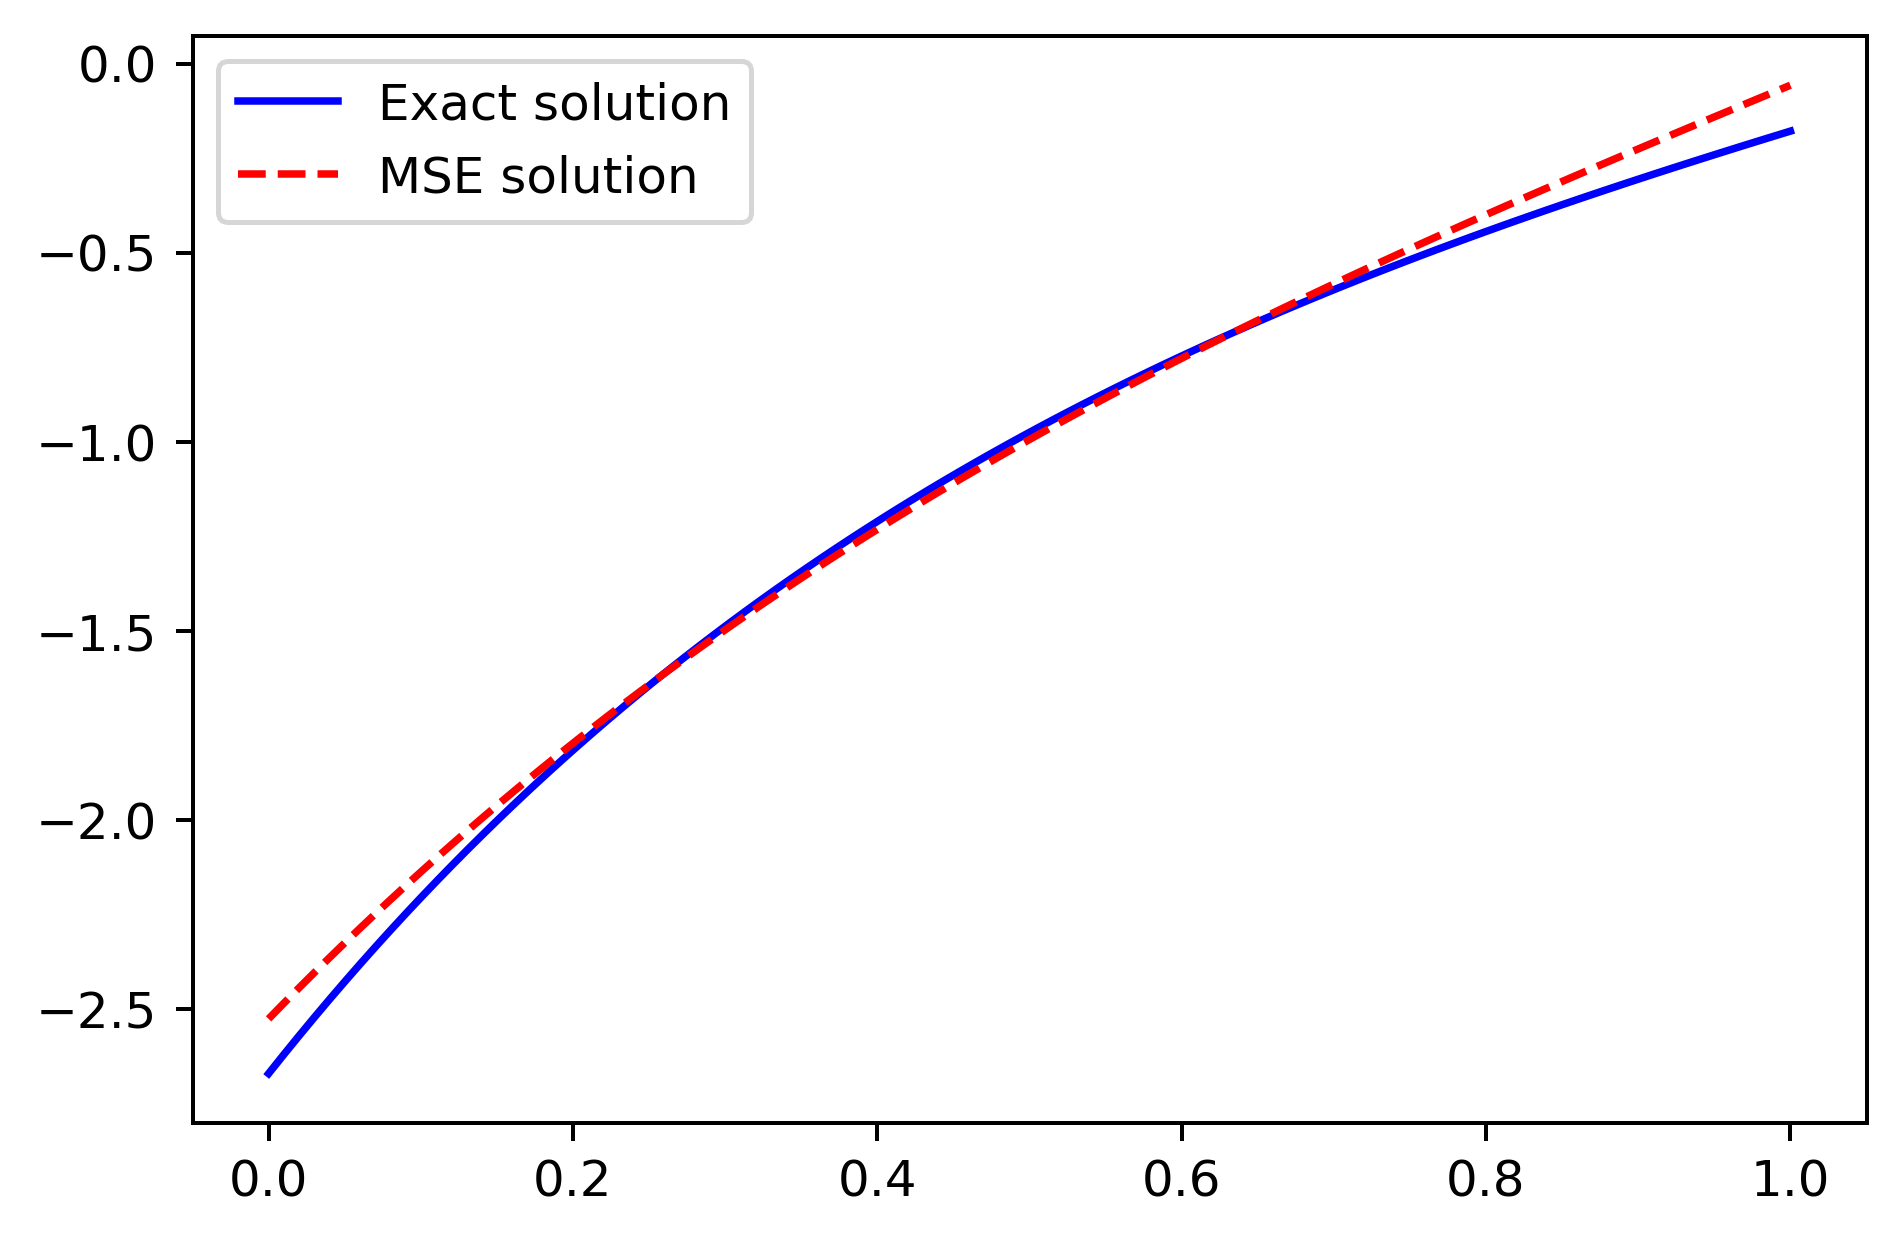

In [26]:
plt.figure(dpi=360)
l1,=plt.plot(t,alpha_true,'b-')
l2,=plt.plot(t,alpha,'r--')
plt.legend(handles=[l1,l2,],labels=['Exact solution','MSE solution'],loc='best')

In [27]:
def get_error(N=100):
    J,alpha,X,Y,count,t = MSE_solution(N)
    alpha_true,t,X_hat = exact_solution(N)
    square_difference = np.square(alpha_true-alpha)
    error = np.sum(square_difference)/N
    return error

#### Warning
The cell may take 1 minute to run

In [28]:
N = [i*100 for i in range(1,16)]
error = []
for i in range(15):
    error.append(get_error(N[i]))

Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent
Solution convergent


Text(0, 0.5, 'Error')

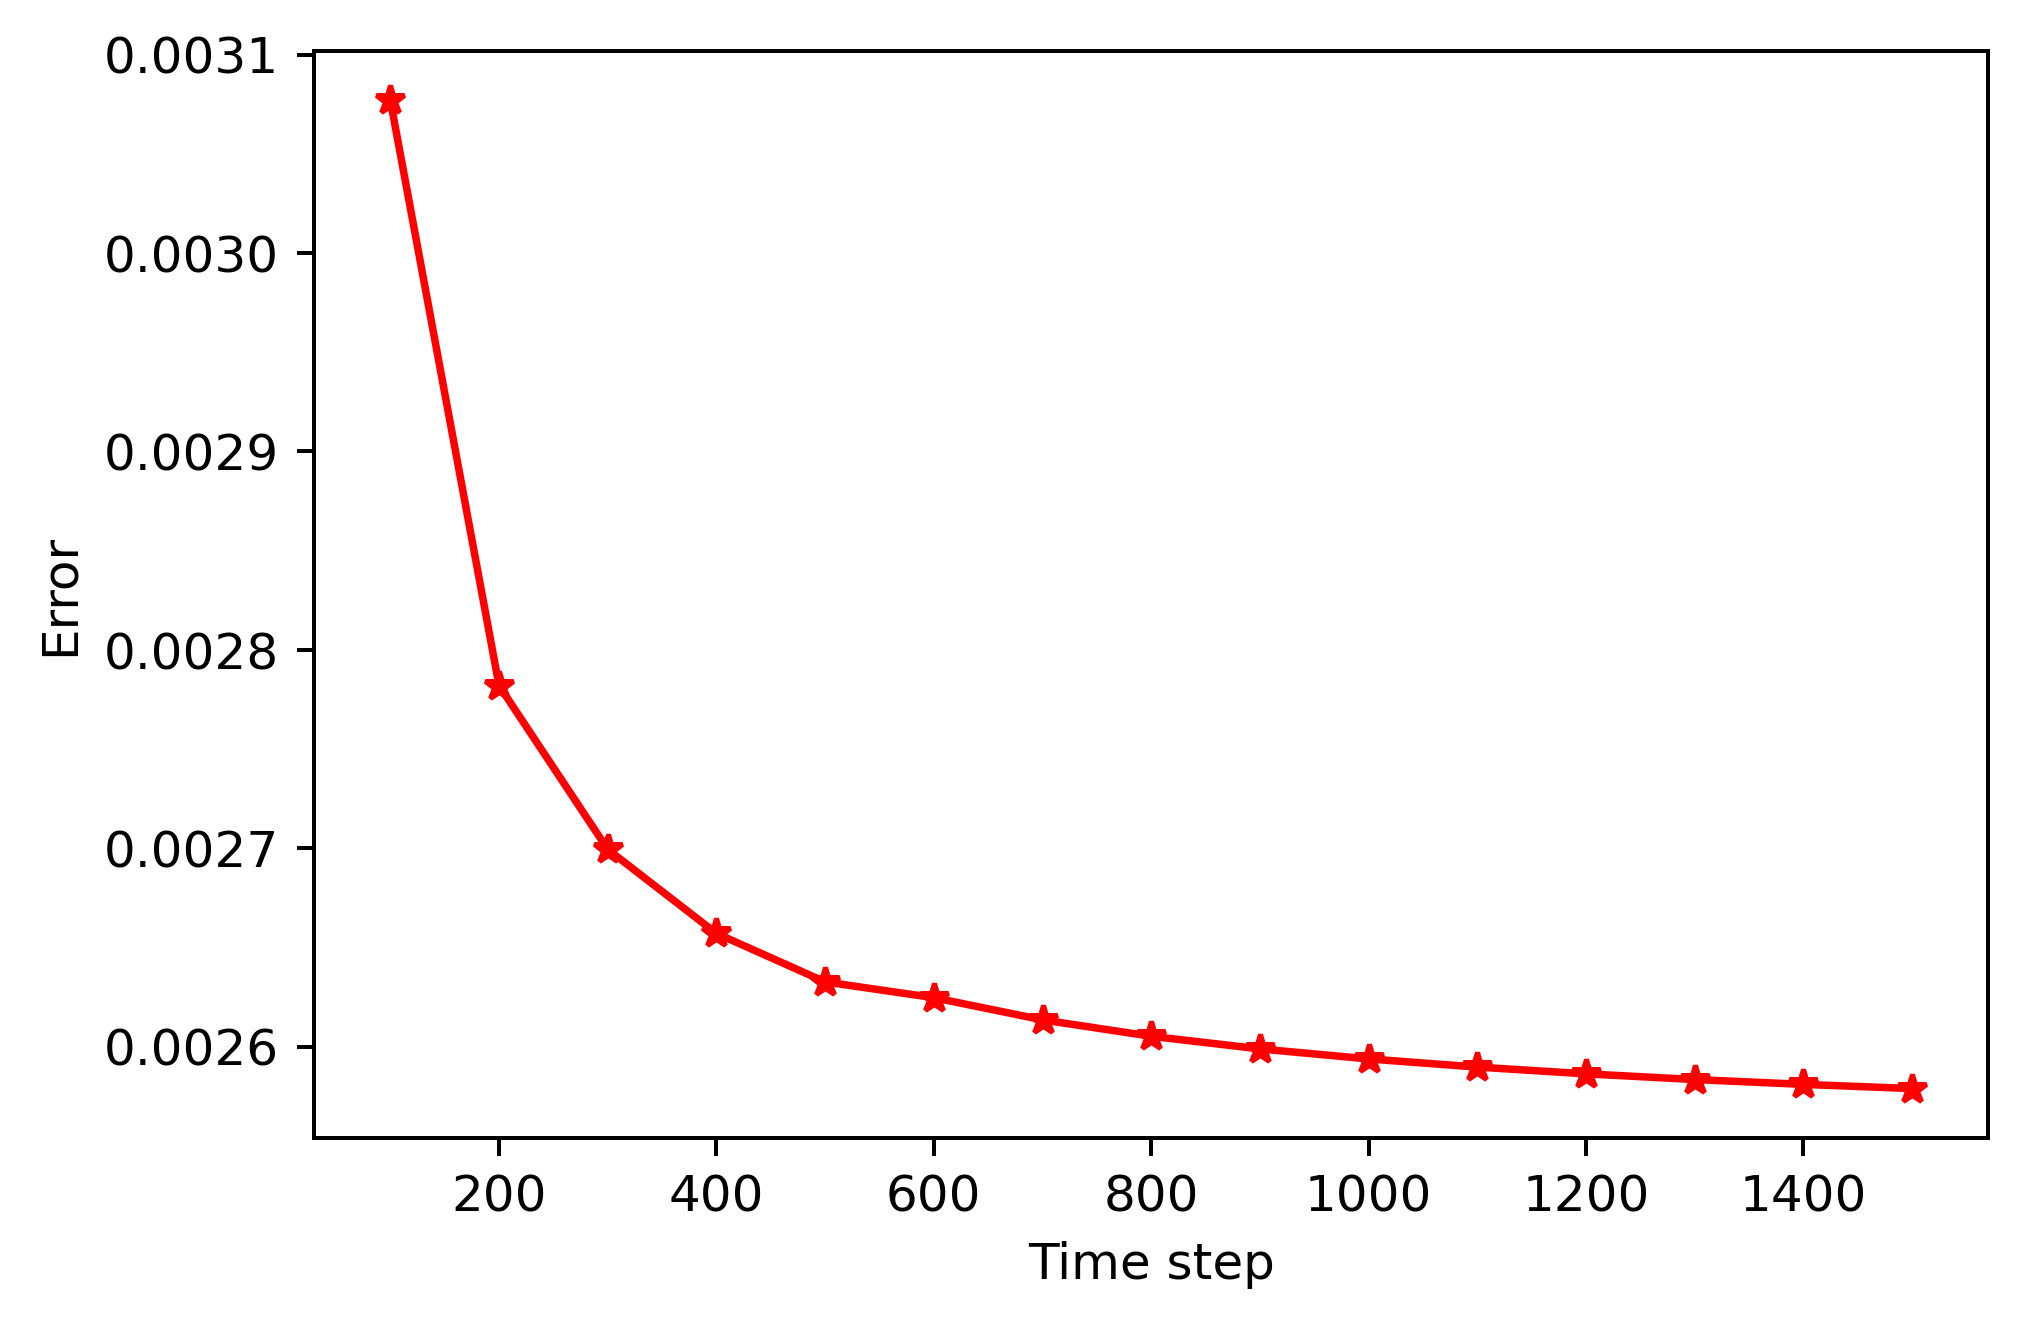

In [29]:
plt.figure(dpi=360)
plt.plot(N,error,'r*-')
plt.xlabel('Time step')
plt.ylabel('Error')

## Discussion

We can see that the approximated solution is very close to the exact solution, and the MSA algorithm convergent well. As the time step increase, the mean square error get smaller. And we will get the more accurate $J$ as the number of time step goes up.

# Part 3(Question 4.1 & 4.2)

## Question 4.1

The model is very similar to last question, difference incurred by the stochastic term, and for convenience, we set all the parameters to be a constant such that our model can be well defiened.
$$d X_{t}=\left[L(t) X_{t}+M(t) \alpha_{t}\right] d t+\sigma(t) d W_{t} \text { for } t \in[0, T], \quad X_{0}=x$$

In [30]:
# set the parameters
sigma = 0.2
N_mc = 20**2; 
N_basis_f = 3

x0 = 1;L = 1; M =1
R = -3;F = 1;C = -10;D = -5
T = 1 ; N = 100; dt = float(T)/N; t=np.linspace(0,T,N)

epsilon = 10**(-5)# Stopping criteria
delta = 10**(-4) # Learning rate

In [31]:
##initial value for alpha
alpha = np.ones((N_mc,N))
alpha = 0.5 * alpha

In [32]:
#  initialize the brownian motion
dW_df = np.zeros((N_mc,N-1))
WT = np.zeros(N_mc)

#simuliate the brownian motion & St for N_mc paths
for i in range(N_mc):
    dW=np.sqrt(dt)*np.random.randn(1,N-1)
    dW_df[i] = dW
    
    W=np.cumsum(dW)
    WT[i] = W[-1]

Solve $\hat X_{t}$ and $\hat Y_t$ numeraically

In [33]:
X = np.zeros((N_mc,N))
X[:,0] = x0*np.ones(N_mc)
def update_x_stoch(X,alpha):
    for j in range(N_mc):
        for i in range(1,N):  
            X[j,i] = X[j,i-1] + (L * X[j,i-1] + M * alpha[j,i-1]) * dt + sigma*dW_df[j,i-1]
    return X

Follow the method in Question 2 to solve the BSDE numerically.
$$
d \hat{Y}_{t}=-\left[L(t) \hat{Y}_{t}+2 C(t) \hat{X}_{t}+2 F(t) \hat{\alpha}\right]d t +\hat Z_t d W_t\text { for } t \in[0, T], \quad \hat{Y}_{T}=2 R \hat{X}_{T}
$$

In [34]:
# initialize the simulated Yt process
def update_y_stoch(Y_df,X,alpha):
    Y_df[:,-1] = np.ones(N_mc)*2*R*X[:,-1]
    Z_df = np.zeros((N_mc,N-1))

    for i in range(N-2,-1,-1):
        #Simulated Yt process
        # according to the iterative formula, estimate the condition value for Z and simulated Y for each time step
        beta_Z = coeffsForCondiExp(X[:,i],Y_df[:,i+1]*dW_df[:,i],N_basis_f)
        Z_df[:,i] = approxCondExp(X[:,i],beta_Z)/dt

        beta_Y = coeffsForCondiExp(X[:,i],Y_df[:,i+1] + (L*Y_df[:,i+1] + 2*C*X[:,i+1] + 2*F*alpha[:,i+1]) * dt,N_basis_f)
        Y_df[:,i] = approxCondExp(X[:,i],beta_Y)
    return Y_df

Find the optimal $\alpha$ that maximized $J$
#### Warning!
The cell below may take 5 minutes to run

In [35]:
flag = True
count = 0
while flag == True:
    count += 1
    X = update_x_stoch(X,alpha)
    Y_df = np.zeros((N_mc,N))
    Y = update_y_stoch(Y_df,X,alpha)

    for i in range(N):## by setting, alpha does not vary among different paths, since it does not control diffusion term.
        alpha[:,i] = alpha[:,i] + delta*(2*D*alpha[:,i]+2*F*X[:,i]+M*Y[:,i])
    
    P_J = 0
    for path in range(N_mc):
        P_J += np.sum((C*X[path]**2+ D*alpha[path]**2 + 2*F*X[path]*alpha[path])*dt) + R*X[path][-1]**2
    P_J = P_J / N_mc

    if count == 1:
        J = P_J
        #print(X[0])
        continue

    if J + epsilon > P_J:
        flag = False
        print("Solution convergent")
        print(f'The value of J is {P_J}')
    elif P_J < J:
        flag = False
        print("Failed")
        print(f'The value of J is {P_J}')
    if count > 10000:
        print('Too many iterations')
        break

    J = P_J


print(f'The total iteration is {count}')

D:\Anaconda\lib\site-packages\numpy\polynomial\hermite_e.py:1371: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


Solution convergent
The value of J is -15.007134809728653
The total iteration is 1504


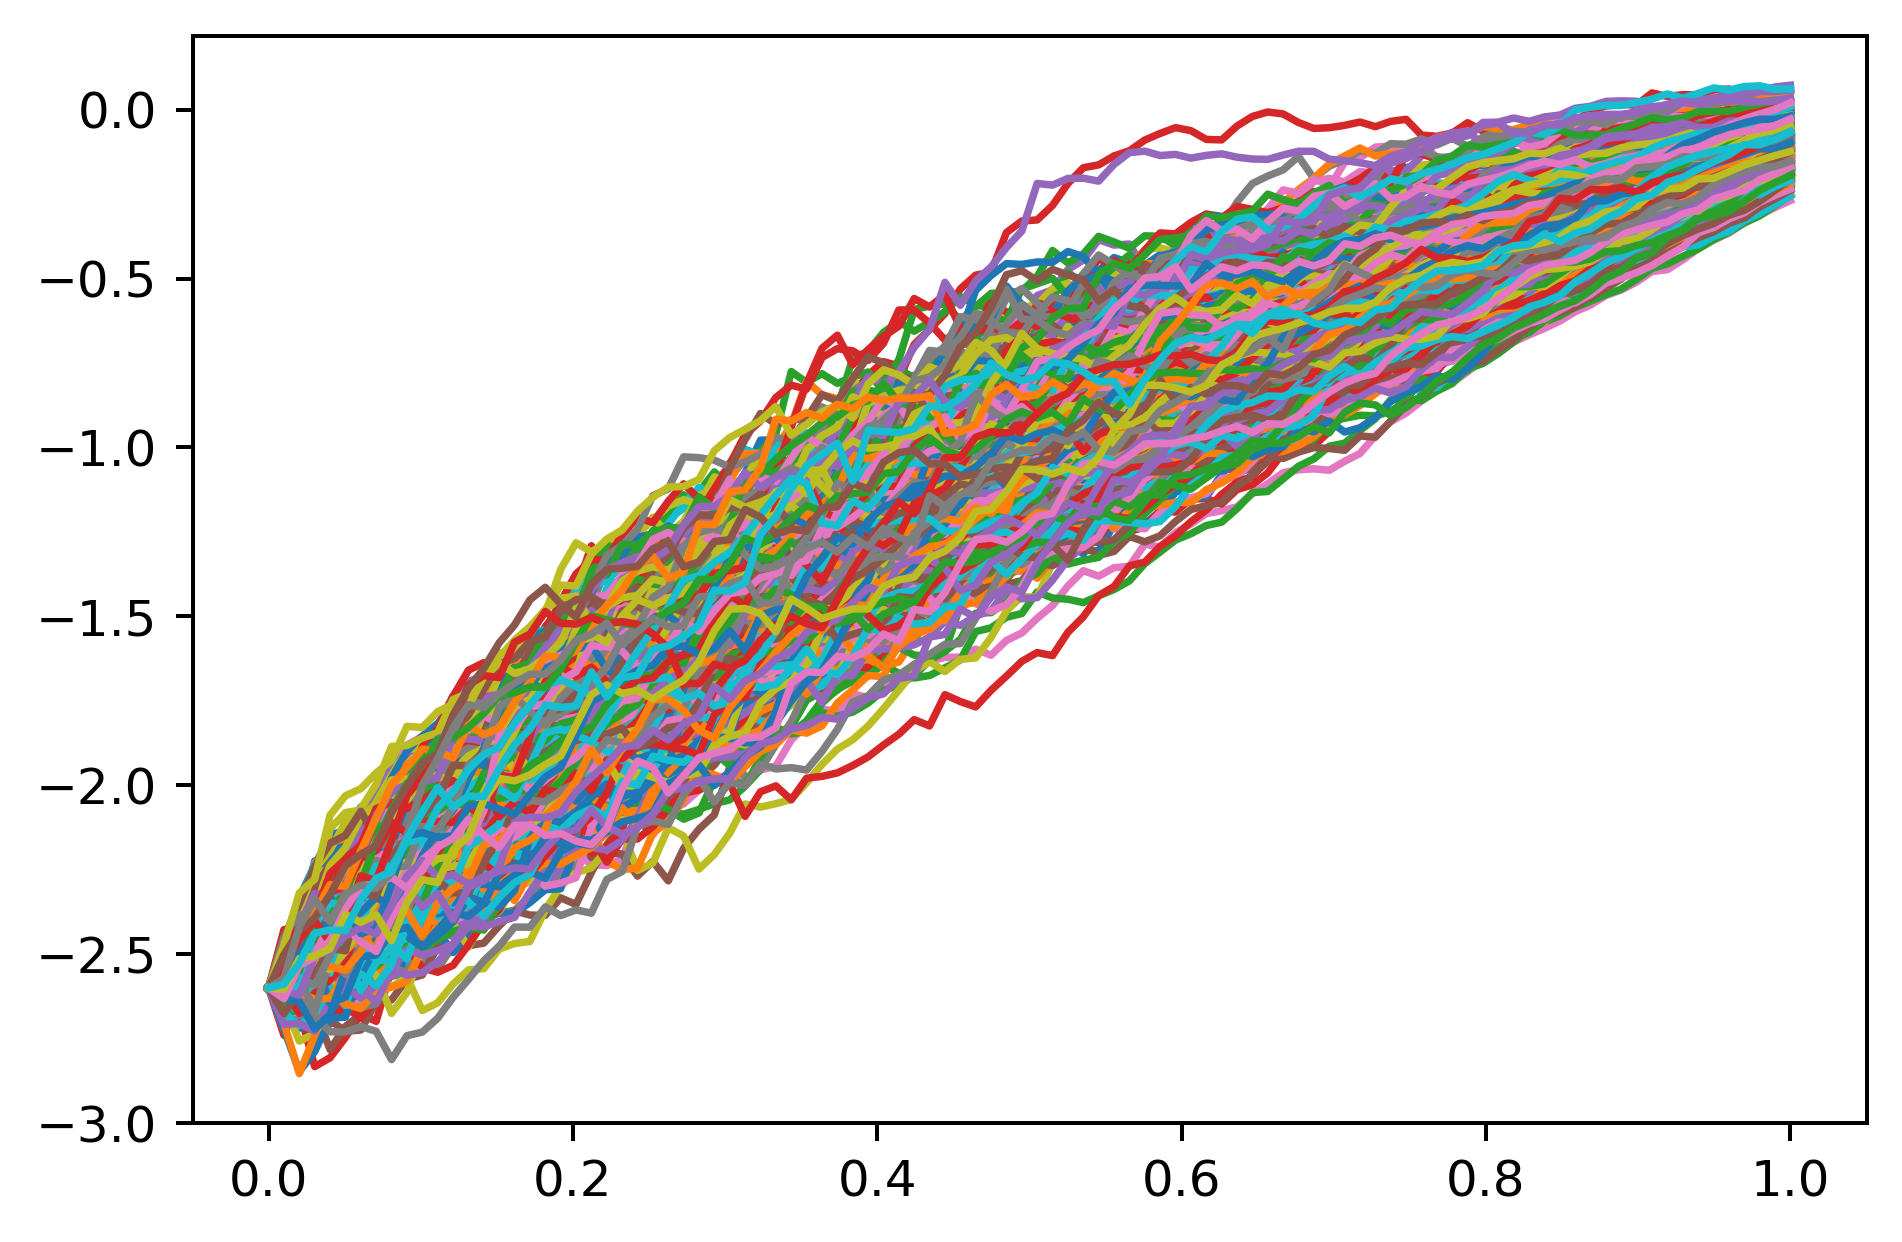

In [36]:
plt.figure(dpi=360)
for i in range(N_mc):
    plt.plot(t,alpha[i])

### Calculate the exact solution 

In [37]:
SS = np.zeros(N)
SS[-1] = R
for i in range(N-2,-1,-1):
    SS[i] = SS[i+1] - ((SS[i+1]*M+F)/D*(M*SS[i+1]+F)-2*L*SS[i+1]-C)*dt
S =np.ones((N_mc,N))
for i in range(N_mc):
    S[i,:] = SS
    
X = np.zeros((N_mc,N))
X[:,0] = x0*np.ones(N_mc)
for i in range(N-1):
    X[:,i+1] = (-(2*L*S[:,i]*X[:,i]+2*C*X[:,i]-2*F/D*M*S[:,i]*X[:,i]-2/D*F**2*X[:,i])*dt+
              2*S[:,i]*sigma*dW_df[:,i] +
              2*S[:,i]*X[:,i])/(2*S[:,i+1])
alpha_true = -(M*S+F)/D*X

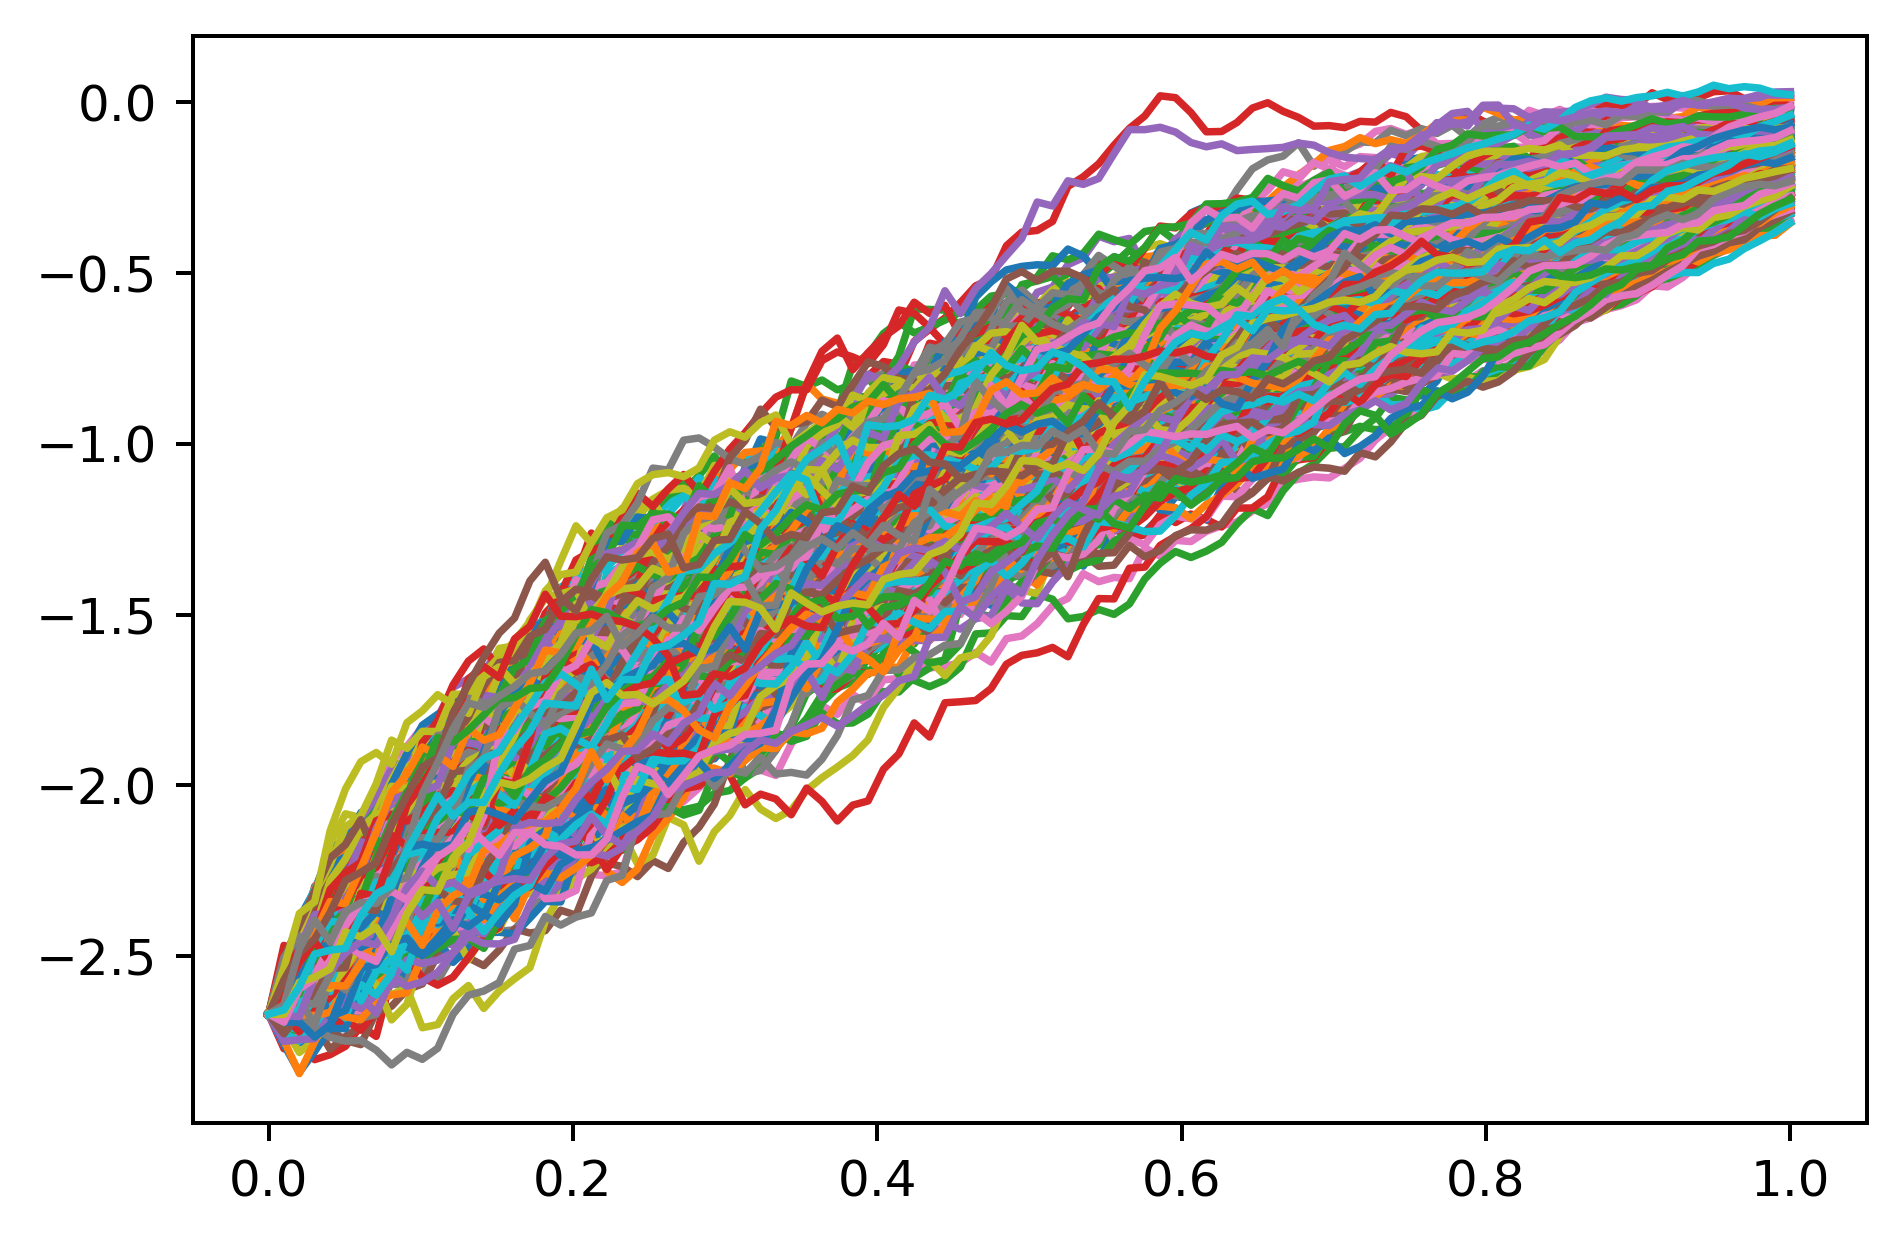

In [38]:
plt.figure(dpi=360)
for i in range(N_mc):
    plt.plot(t,alpha_true[i])

Compare the exact solution with the numerical solution by rondomly choose one sample from all solution. You can run the cell below multiple times, each time you will get different sample solution.

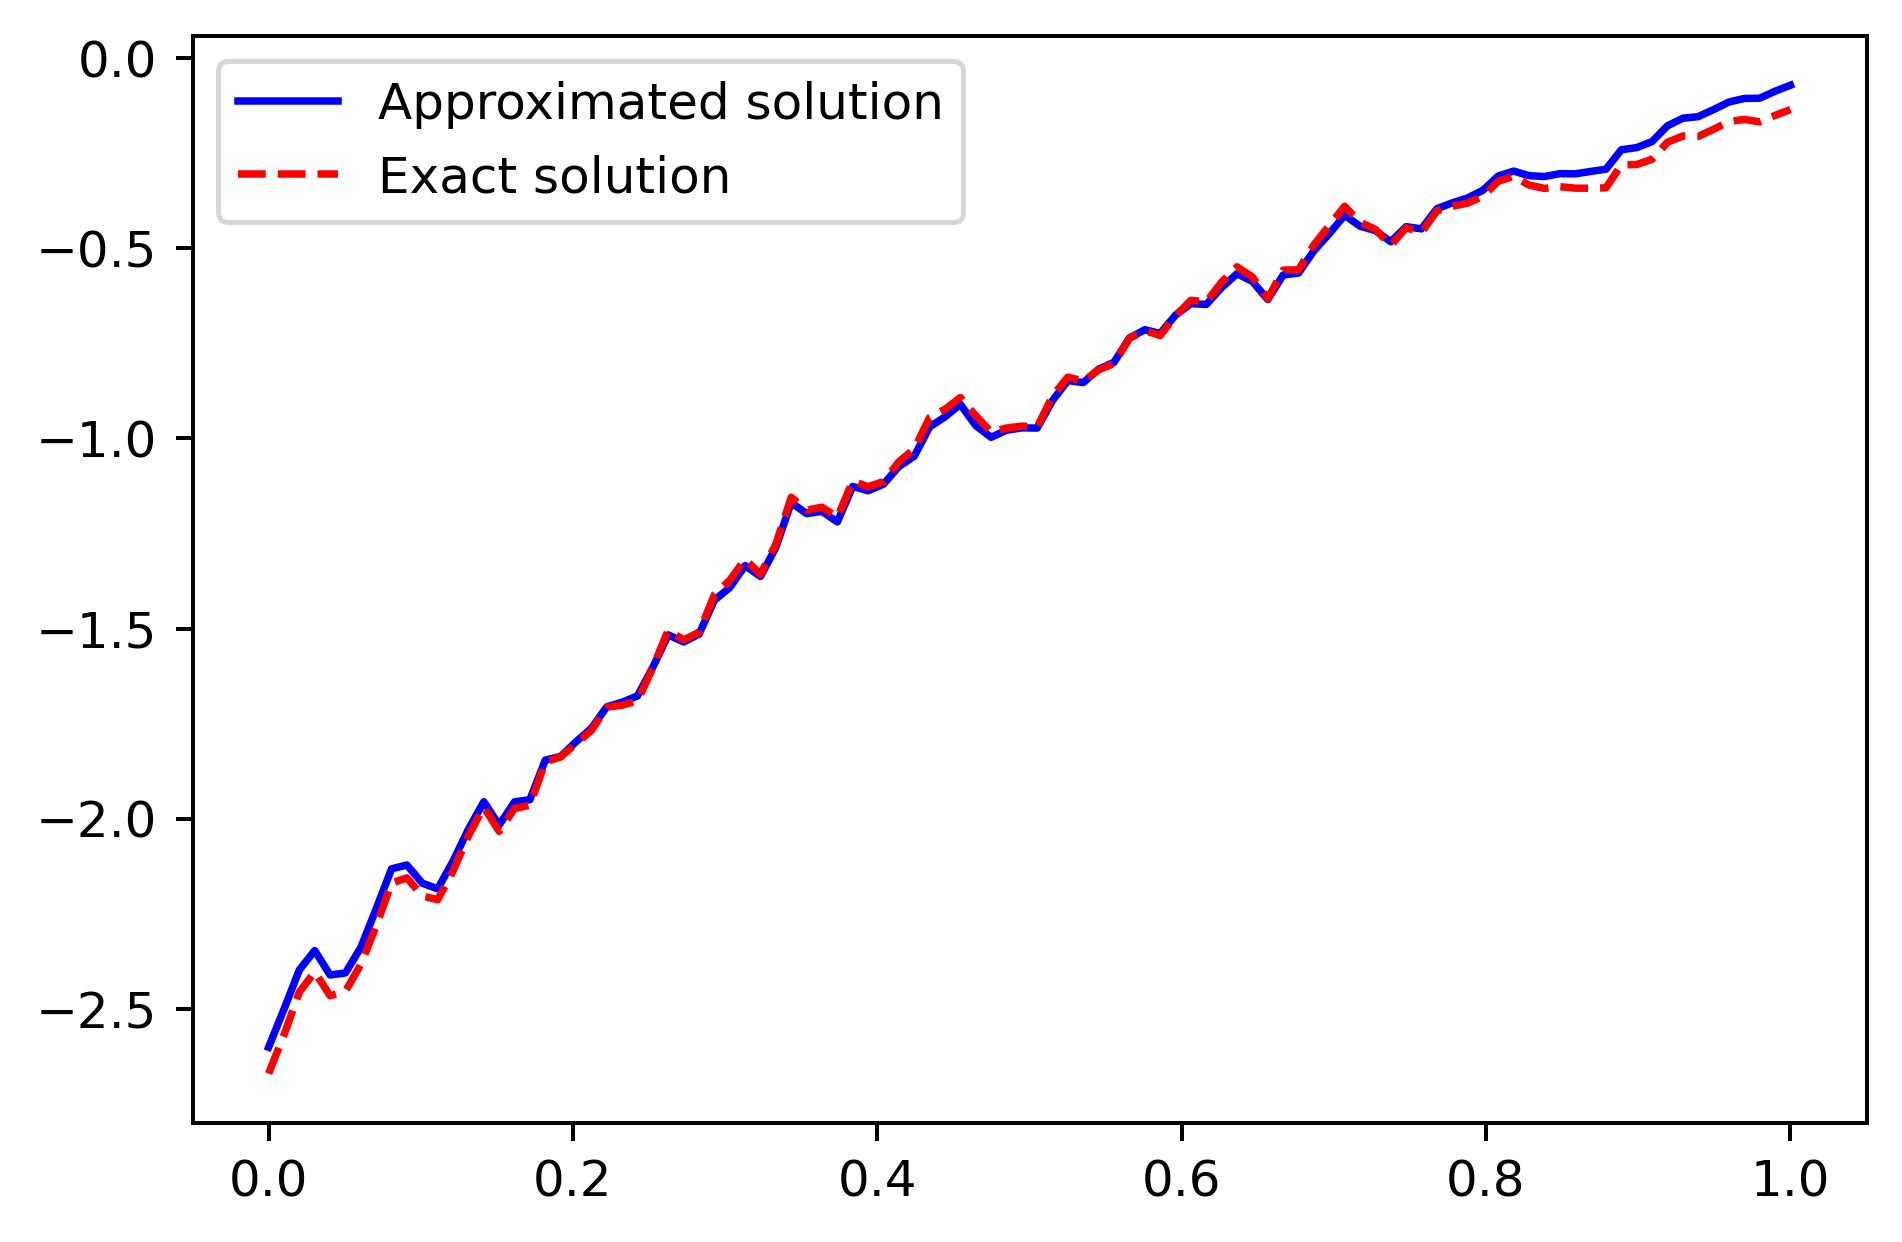

In [40]:
sample_path_index = rng.integers(N_mc)
plt.figure(dpi=360)
l1, = plt.plot(t,alpha[sample_path_index],'b-')
l2, = plt.plot(t,alpha_true[sample_path_index],'r--')
plt.legend(handles=[l1,l2,],labels=['Approximated solution','Exact solution'],loc='best')

### Discussion

As we can see, the numerical solution have a very good approximation comparing to the exact solution through our basic settings, however, due to the efficiency of computer, generate multiple case and then calculate the error will take lots of time. Roughly speaking, the error may have similar behavior as what we have discussed in Quesiton 2.

## Quesiton 4.2

In [54]:
# expand the input X to the hermite series within hermiteOrder
def get_basis(X,hermiteOrder):
    basis = []
    hermiteOrder_matrix = np.identity(hermiteOrder)
    for i in range(hermiteOrder):
        basis.append(hermeval(X, hermiteOrder_matrix[i]))
    return np.array(basis)

# given two vectors X1, X2, and Y, return the coefficients of the vectors of Hermite polynomials expanded by X1 and X2
def fix_coeffsForCondiExp(X1,X2,Y,hermiteOrder):
    A = get_basis(X1,hermiteOrder)
    B = get_basis(X2,hermiteOrder)
    list = []
    for i in range(hermiteOrder):
        for j in range(hermiteOrder):
            list.append(A[i]*B[j])
    XX = np.array(list).T
    beta= np.linalg.lstsq(XX,Y, rcond=None)[0]
    return beta

# Obtaining the conditional Expectation on two input vectors
def fix_approxCondExp(X1,X2,beta,hermiteOrder):
    A = get_basis(X1,hermiteOrder)
    B = get_basis(X2,hermiteOrder)
    list = []
    for i in range(hermiteOrder):
        for j in range(hermiteOrder):
            list.append(A[i]*B[j])
    XX = np.array(list).T
    return XX.dot(beta)

### Set parameters for Merton problem with no consumption for an utility function(log x)

In [55]:
# set the parameters
r = 1/100
u = 3/100
x0 = 1
k = 0.5 #1.5768
theta = 0.2 #0.0398
sigma = 0.2
rou = -0.707
v0 = 0.5

N_mc = 20**2; 
N_basis_f = 3
T = 1 ; N = 100; dt = float(T)/N; t=np.linspace(0,T,N)

epsilon = 10**(-5)##for judging J[i] and J[i+1]
delta = 10**(-4)###for gradient alpha

## initialize needed processes

In [56]:
# This time, we will use two brownion motions for estimating conditional expectation
#  initialize the brownian motion
Wiener1 = np.zeros((N_mc,N))
Wiener2 = np.zeros((N_mc,N))
dW1_df = np.zeros((N_mc,N-1))
dW2_df = np.zeros((N_mc,N-1))
#simuliate the brownian motion & St for N_mc paths
for i in range(N_mc):
    dW1=np.sqrt(dt)*np.random.randn(1,N-1)
    dW1_df[i] = dW1
    W1=np.cumsum(dW1)
    W1=np.insert(W1,0,0)
    Wiener1[i] = W1
    
    dW2=np.sqrt(dt)*np.random.randn(1,N-1)
    dW2_df[i] = dW2
    W2=np.cumsum(dW2)
    W2=np.insert(W2,0,0)
    Wiener2[i] = W2

In [57]:
##initial value for alpha
alpha = np.ones((N_mc,N))
alpha = 0.5 * alpha

In [58]:
v = np.zeros((N_mc,N))
v[:,0] = v0*np.ones(N_mc)
def update_v_merton(v):
    for i in range(1,N):  
        v[:,i] = v[:,i-1] + k*(theta-v[:,i-1])*dt + sigma*np.sqrt(v[:,i-1])*(rou*dW1_df[:,i-1]+np.sqrt(1-rou**2)*dW2_df[:,i-1])            
    return v
v = update_v_merton(v)

In [59]:
X = np.zeros((N_mc,N))
X[:,0] = x0*np.ones(N_mc)
def update_x_merton(X,v,alpha):
    for i in range(1,N):  
        X[:,i] = X[:,i-1] + X[:,i-1]*((u-r)*alpha[:,i-1]+r)*dt + alpha[:,i-1]*X[:,i-1]*np.sqrt(v[:,i-1])*dW1_df[:,i-1]
    return X

In [60]:
#  initialize the simulated Yt process
def update_y_merton(Y_df,X,v,alpha):
    Y_df[:,-1] = np.ones(N_mc)*1/X[:,-1]###utility = log x
    Z_df = np.zeros((N_mc,N-1))

    for i in range(N-2,-1,-1):
        #Simulated Yt process
        # according to the iterative formula, estimate the condition value for Z and simulated Y for each time step
        beta_Z = fix_coeffsForCondiExp(Wiener1[:,i],Wiener2[:,i],Y_df[:,i+1]*dW1_df[:,i],N_basis_f)#(X[:,i],Y_df[:,i+1]*dW1_df[:,i],N_basis_f)
        Z_df[:,i] = fix_approxCondExp(Wiener1[:,i],Wiener2[:,i],beta_Z,N_basis_f)/dt #approxCondExp(X[:,i],beta_Z)/dt

        beta_Y = fix_coeffsForCondiExp(Wiener1[:,i],Wiener2[:,i],Y_df[:,i+1] + ((u-r)*alpha[:,i+1]*Y_df[:,i+1]+
                                                         r*Y_df[:,i+1]+
                                                         alpha[:,i+1]*v[:,i+1]**0.5*Z_df[:,i])*dt,N_basis_f)
       
        
        Y_df[:,i] = fix_approxCondExp(Wiener1[:,i],Wiener2[:,i],beta_Y,N_basis_f)
    return [Y_df,Z_df]


## simulated experiment
Waring! The cell below may take 6-10 minutes to run.

In [61]:
flag = True
count = 0
while flag == True:
    count += 1

    X = update_x_merton(X,v,alpha)
    Y_df = np.zeros((N_mc,N))
    Y = update_y_merton(Y_df,X,v,alpha)[0]
    Z = update_y_merton(Y_df,X,v,alpha)[1]

    for i in range(N-1):## by setting, alpha does not vary among different paths, since it does not control diffusion term.
        alpha[:,i] = alpha[:,i] + delta*(X[:,i]*(u-r)* Y[:,i]+X[:,i]*np.sqrt(v[:,i])*Z[:,i])
                                  #delta * ((mu - r) * X[:,i] * Y[:,i] + X[:,i] * np.sqrt(V[:,i]) * Z[:,i])
    P_J = 0
    for path in range(N_mc):
        P_J += np.log(X[path][-1])
    P_J = P_J / N_mc

    if count == 1:
        J = P_J
        #print(X[0])
        continue

    if J + epsilon > P_J:
        flag = False
        print("solution convergent")
        print([P_J,J])
    elif P_J < J:
        flag = False
        print("Failed")
        print([P_J,J])
    if count > 100000:
        print('Too many iterations')
        break

    J = P_J


print(count)

solution convergent
[0.0772764198179063, 0.0772710750140626]
963


### plot our strategy

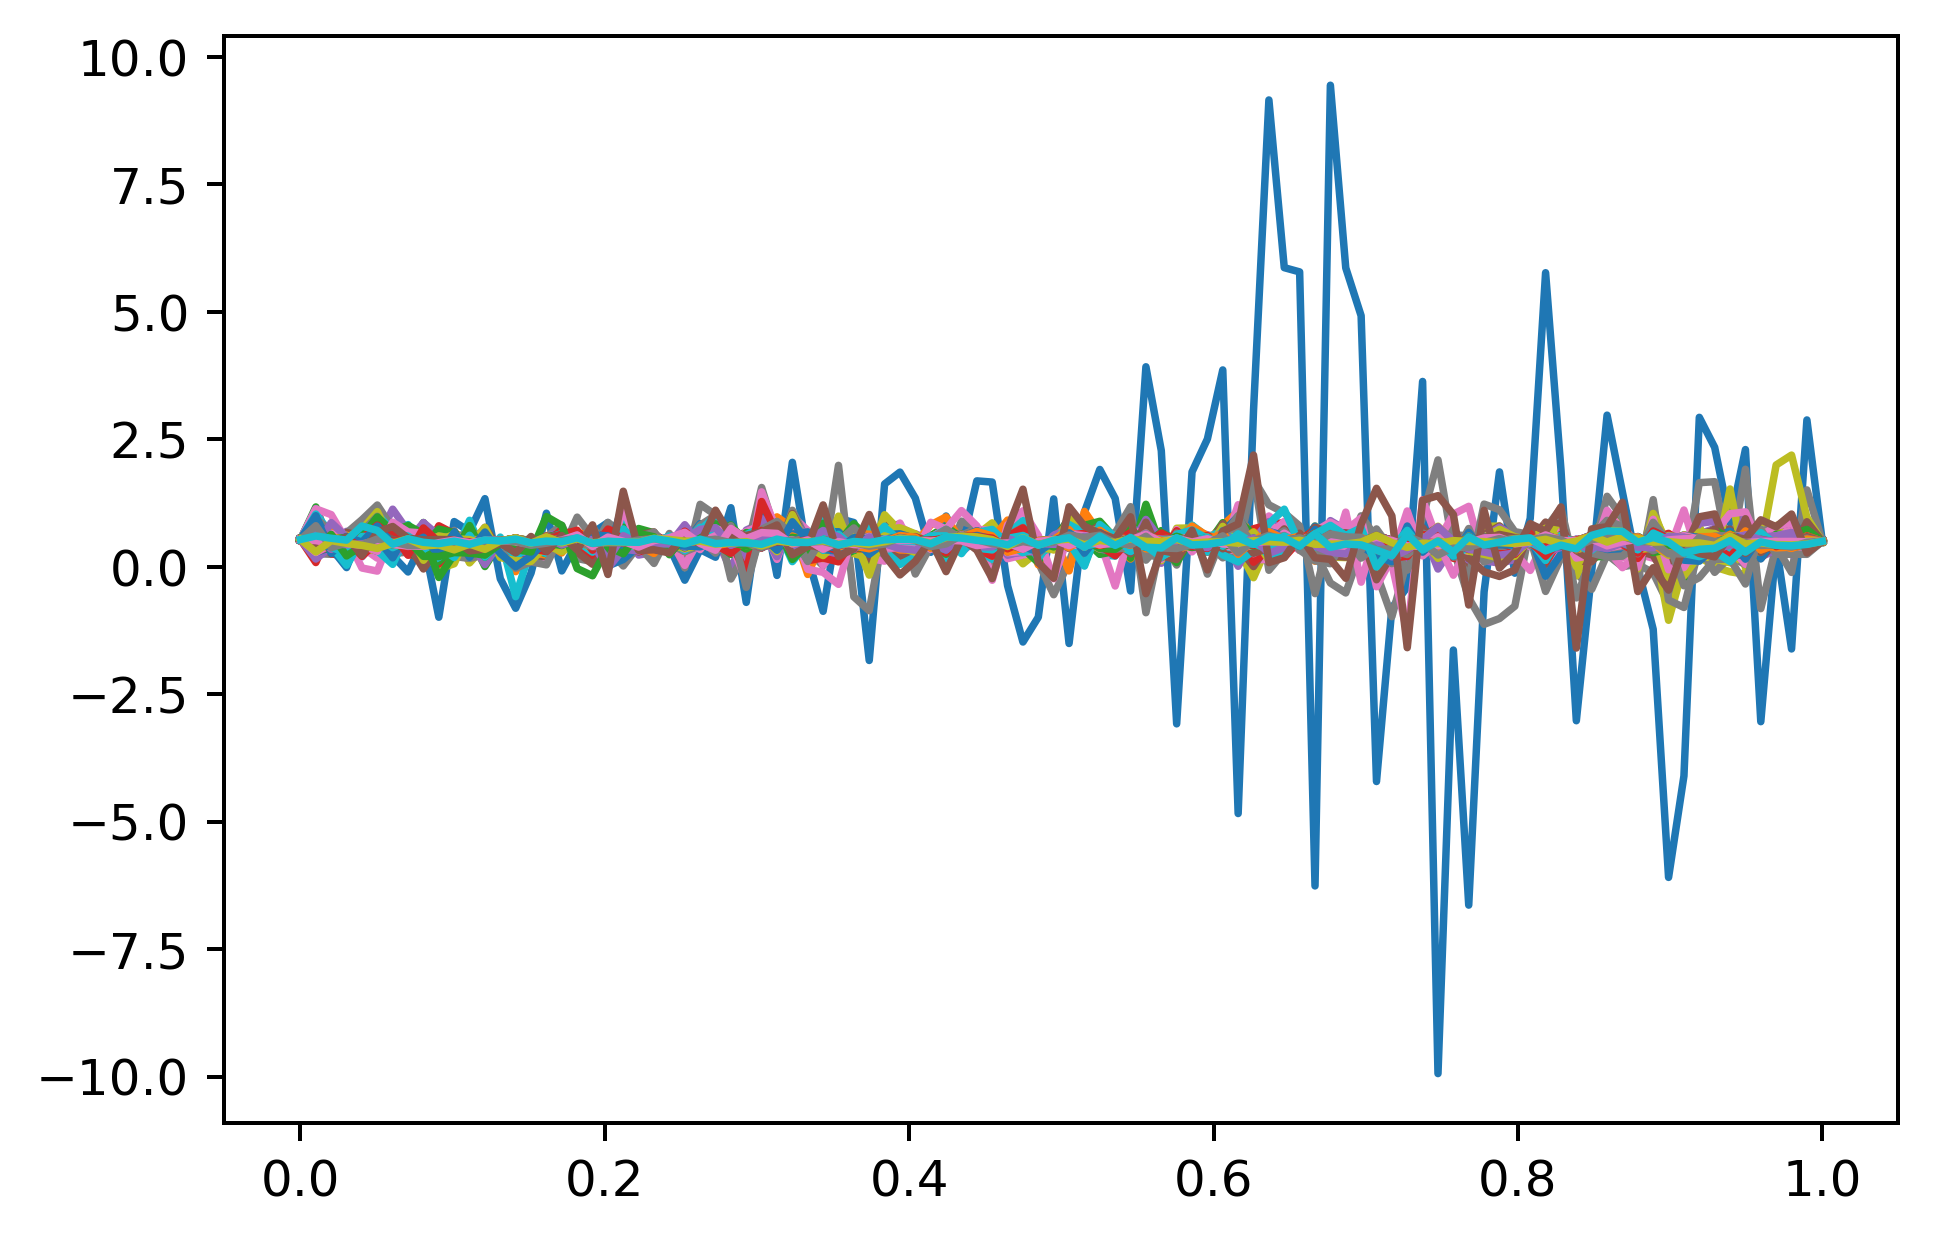

In [62]:
plt.figure(dpi=360)
for i in range(N_mc):
    plt.plot(t,alpha[i])

We generate 400 paths, based on which we estimate the conditional expectation for Y and Z at each time step.  By following the rules of updating J using a log utility function, the solution eventually converge and we get optimal strategies i.e. our proportion of wealth in risky asset for each path shown in the above graph. 